<a href="https://colab.research.google.com/github/tejasnavalkhe/Optimising-Car-Sharing-Profitability-with-a-Regional-Pricing-Strategy/blob/master/code/Data%20Cleaning%20and%20Feature%20Engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement:

* Create Dynamic Pricing model for different locations and vehicle types, hourly and daily prices.

# Know the Data

* `booking_billed_duration`:
    1. This is in minutes.
    2. For better understanding consider converting it to hour. The formula is:
        `booking_billed_duration (in hours) = booking_billed_duration / 60`
    3. However, this is already done and result is stored in `booking_rates_hours`, `booking_rates_24hours`, `booking_rates_overnight`.
    4. If hours are less than 8 then it is stored in `booking_rates_hours` else `booking_rates_24hours`.
* `booking_mileage`:
    1. This is in miles.

* `booking_actual_cost_distance`:
    1. This is in Pound and Pence
    2. The formula is:
        ``booking_mileage * per mile (Petrol / EV)``

* `booking_actual_cost_time`:
    1. This is in Pound and Pence.
    2. The formula is:
        ``booking_rates_hours (or) booking_rates_24hours` * hourly_rates (or) daily_rates`

        _NOTE: Add columns hourly_rates and daily_rates_

# 1. Data and Library Loading

## 1.1. Load libraries

In [ ]:
# Import required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings

# Display all the columns of the dataframe
pd.pandas.set_option('display.max_columns', None)

# Ignore all warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1.2. Load data

In [ ]:
# Data location
DATA_PATH = "/content/drive/MyDrive/MSc Dissertation/data/"

In [ ]:
# Load all files

bookings_2019_df = pd.read_csv(f"{DATA_PATH}2019 Bookings.csv", low_memory=False)
bookings_2020_df = pd.read_csv(f"{DATA_PATH}2020 Bookings.csv", low_memory=False)
bookings_2021_df = pd.read_csv(f"{DATA_PATH}2021 Bookings.csv", low_memory=False)
bookings_2022_df = pd.read_csv(f"{DATA_PATH}2022 Bookings.csv", low_memory=False)
bookings_2023_df = pd.read_csv(f"{DATA_PATH}2023 Bookings.csv", low_memory=False)
bookings_2024_df = pd.read_csv(f"{DATA_PATH}2024 Bookings.csv", low_memory=False)
tariff_df = pd.read_csv(f"{DATA_PATH}Diff Tariffs.csv", low_memory=False)


In [ ]:
# Merge all files into one dataframe
bookings_df = pd.concat([bookings_2019_df, bookings_2020_df, bookings_2021_df, bookings_2022_df, bookings_2023_df, bookings_2024_df])

# Print the shape of the dataframe
print(f"The shape of the merged dataframe: {bookings_df.shape}")

The shape of the merged dataframe: (721193, 39)


In [ ]:
# Reset index
bookings_df.reset_index(drop=True, inplace=True)

# 2. Data Cleaning and Feature Engineering

In [ ]:
# Look at the data
bookings_df.head()

,account_id,Contract,user_id,vehicle_description,vehicle_registration,vehicle_communication_id,vehicle_operator_name,vehicle_office_use,location_description,location_office_use,booking_id,booking_reservation,booking_maintenance,booking_start,booking_end,booking_duration,booking_actual_start,booking_actual_end,booking_actual_duration,booking_billed_start,booking_billed_end,booking_billed_duration,booking_mileage,booking_tariff,booking_rates_hours,booking_rates_24hours,booking_rates_overnight,booking_estimated_cost,booking_actual_cost_distance,booking_actual_cost_time,booking_actual_cost_total,booking_credits_used,booking_transactions_value,booking_total_paid,booking_status,booking_ended_early,booking_created_at,booking_cancelled_at,booking_cancellation_reason
0,9ef6f9f2-bb87-11e8-8478-3392d6ed7026,PAYG,5cab890a-bb87-11e8-8c45-8b43f7434530,RETIRED- White Toyota Yaris Hybrid NJ68 VOP Au...,NJ68 VOP,NaN,Co-wheels,PAYG,NaN,NaN,ac2d5146-2cee-11ea-a00a-57b3c15418c7,26692666,no,01/01/2020 23:45,01/02/2020 0:15,30,01/02/2020 0:11,01/02/2020 0:35,24.0,01/01/2020 23:45,01/02/2020 0:45,60,16.0,Co-wheels Standard Medium,1.0,0,0,2.75,2.88,5.5,8.38,0,-8.38,8.38,ended,no,01/01/2020 23:30,NaN,NaN
1,837460ea-1a02-11ea-9ddd-919b17a2c51c,PAYG,e4f9362e-1822-11ea-8de1-473e949dd300,RETIRED - White Toyota Aygo X-Play Nav (NL66 NKZ),NL66 NKZ,NaN,Co-wheels,PAYG,Lower Maudlin DNU,NaN,fc59ba9c-2ce9-11ea-8efc-bfa292f04054,26692660,no,01/01/2020 23:00,01/02/2020 8:00,540,01/01/2020 23:06,01/02/2020 1:24,138.0,01/01/2020 23:00,01/02/2020 8:00,540,82.0,Co-wheels Standard Small,0.0,0,1,9.50,14.76,9.5,24.26,0,-24.26,24.26,ended,no,01/01/2020 22:56,NaN,NaN
2,bcdf83ac-cf78-11e9-a7b5-eba9440aff95,PAYG,5b58ca44-cf78-11e9-8a88-f32ff93f96dc,RETIRED - Renault Zoe EV (DL68 LNK),DL68 LNK,NaN,Co-wheels,PAYG,Bristol - Effingham Road,BRI018,1cf7fae6-2ce7-11ea-a970-fbf7b3786523,26692658,no,01/01/2020 22:45,01/02/2020 2:30,225,01/01/2020 22:46,01/02/2020 2:01,195.0,01/01/2020 22:45,01/02/2020 2:30,225,5.0,Co-wheels Standard Electric,0.0,0,1,11.00,0.0,11.0,11.0,0,-11.00,11.00,ended,no,01/01/2020 22:36,NaN,NaN
3,10d4ff50-c68a-490b-9831-73a2a53a789e,Franchise,27a79ce4-eeff-4a45-9727-cff211058712,RETIRED - Toyota Yaris Hybrid NAV (NJ18 VTX),NJ18 VTX,NaN,Co-wheels Birmingham,PAYG,NaN,NaN,887d643e-2ce9-11ea-be0d-d996759c0cec,26692659,no,01/01/2020 22:45,01/02/2020 22:45,1440,01/01/2020 22:54,01/02/2020 22:30,1416.0,01/01/2020 22:45,01/02/2020 22:45,1440,112.0,Co-wheels Standard Medium,0.0,1,0,38.50,20.16,38.5,58.66,0,-83.66,0.00,ended,yes,01/01/2020 22:53,NaN,NaN
4,ad4720a8-371c-11e8-9c54-45ef183a979b,Contract,84845dc8-a7cb-11e8-a9fa-4fcddbe2d33e,RETIRED - SEAT Ateca 4X4 (NG18 EKY),NG18 EKY,NaN,Co-wheels,Pool Car - Telematics,North Shields - North Tyneside General Hospital,NTH006,33c8d096-2b58-11ea-9f3f-5f76ab89e87a,25691980,no,01/01/2020 22:30,01/02/2020 8:45,615,01/01/2020 22:49,01/02/2020 8:29,580.0,01/01/2020 22:30,01/02/2020 8:45,615,40.0,Billing Exempt (24/7) (Default),10.25,0,0,0.00,0.0,0.0,0.0,0,0.00,0.00,ended,no,12/30/2019 23:00,NaN,NaN


In [ ]:
# Select only PAYG fleets
bookings_filtered_df = bookings_df[bookings_df['Contract'] == 'PAYG']
bookings_filtered_df.head()

,account_id,Contract,user_id,vehicle_description,vehicle_registration,vehicle_communication_id,vehicle_operator_name,vehicle_office_use,location_description,location_office_use,booking_id,booking_reservation,booking_maintenance,booking_start,booking_end,booking_duration,booking_actual_start,booking_actual_end,booking_actual_duration,booking_billed_start,booking_billed_end,booking_billed_duration,booking_mileage,booking_tariff,booking_rates_hours,booking_rates_24hours,booking_rates_overnight,booking_estimated_cost,booking_actual_cost_distance,booking_actual_cost_time,booking_actual_cost_total,booking_credits_used,booking_transactions_value,booking_total_paid,booking_status,booking_ended_early,booking_created_at,booking_cancelled_at,booking_cancellation_reason
0,9ef6f9f2-bb87-11e8-8478-3392d6ed7026,PAYG,5cab890a-bb87-11e8-8c45-8b43f7434530,RETIRED- White Toyota Yaris Hybrid NJ68 VOP Au...,NJ68 VOP,NaN,Co-wheels,PAYG,NaN,NaN,ac2d5146-2cee-11ea-a00a-57b3c15418c7,26692666,no,01/01/2020 23:45,01/02/2020 0:15,30,01/02/2020 0:11,01/02/2020 0:35,24.0,01/01/2020 23:45,01/02/2020 0:45,60,16.0,Co-wheels Standard Medium,1.0,0,0,2.75,2.88,5.5,8.38,0,-8.38,8.38,ended,no,01/01/2020 23:30,NaN,NaN
1,837460ea-1a02-11ea-9ddd-919b17a2c51c,PAYG,e4f9362e-1822-11ea-8de1-473e949dd300,RETIRED - White Toyota Aygo X-Play Nav (NL66 NKZ),NL66 NKZ,NaN,Co-wheels,PAYG,Lower Maudlin DNU,NaN,fc59ba9c-2ce9-11ea-8efc-bfa292f04054,26692660,no,01/01/2020 23:00,01/02/2020 8:00,540,01/01/2020 23:06,01/02/2020 1:24,138.0,01/01/2020 23:00,01/02/2020 8:00,540,82.0,Co-wheels Standard Small,0.0,0,1,9.50,14.76,9.5,24.26,0,-24.26,24.26,ended,no,01/01/2020 22:56,NaN,NaN
2,bcdf83ac-cf78-11e9-a7b5-eba9440aff95,PAYG,5b58ca44-cf78-11e9-8a88-f32ff93f96dc,RETIRED - Renault Zoe EV (DL68 LNK),DL68 LNK,NaN,Co-wheels,PAYG,Bristol - Effingham Road,BRI018,1cf7fae6-2ce7-11ea-a970-fbf7b3786523,26692658,no,01/01/2020 22:45,01/02/2020 2:30,225,01/01/2020 22:46,01/02/2020 2:01,195.0,01/01/2020 22:45,01/02/2020 2:30,225,5.0,Co-wheels Standard Electric,0.0,0,1,11.00,0.0,11.0,11.0,0,-11.00,11.00,ended,no,01/01/2020 22:36,NaN,NaN
6,29f5ecce-4a9d-11e6-a70a-f39821a3496c,PAYG,622754ee-4a9c-11e6-a82f-4ba9e3c70859,RETIRED - BMW i3 Electric Vehicle (Automatic),NL69 JZM,1343.0,Co-wheels,PAYG - Funded,NaN,NaN,513090a0-2ce4-11ea-9bfc-a300cc72d38e,25692652,no,01/01/2020 22:15,01/02/2020 8:00,585,01/01/2020 22:22,01/02/2020 6:44,502.0,01/01/2020 22:15,01/02/2020 8:00,585,113.0,Co-wheels Standard Electric,0.0,0,1,11.00,0.0,11.0,11.0,0,-11.00,11.00,ended,no,01/01/2020 22:16,NaN,NaN
7,68c151d8-0d0d-11ea-bed8-ebcb87cb5715,PAYG,efa7004a-0d0c-11ea-b0b4-590f743c744f,White Toyota Yaris Petrol Hybrid (Automatic) -...,ND19 HWY,1211.0,Co-wheels,PAYG - Funded,Newbury - Boundary Road,NEW001,591b7a98-2cd8-11ea-a341-71665a42c0e8,25692603,no,01/01/2020 21:30,01/01/2020 23:30,120,01/01/2020 21:29,01/01/2020 23:28,119.0,01/01/2020 21:30,01/01/2020 23:30,120,6.0,Co-wheels Standard Medium,2.0,0,0,11.00,1.08,11.0,12.08,0,-12.08,11.00,ended,no,01/01/2020 20:50,NaN,NaN


In [ ]:
# Print the shape of the dataframe for PAYG fleets
print(f"The shape of the PAYG fleet dataframe: {bookings_filtered_df.shape}")

The shape of the PAYG fleet dataframe: (436354, 39)


## 2.1. Remove rows where '?' presents

In [ ]:
# Check each column for the presence of '?' and create a boolean mask
mask = bookings_filtered_df.apply(lambda x: x.astype(str).str.contains(r'\?', regex=True))

# Filter the DataFrame based on the mask to get rows where any column contains '?'
filtered_data = bookings_filtered_df[mask.any(axis=1)]

# Drop rows based on the mask
bookings_filtered_df = bookings_filtered_df[~mask.any(axis=1)]

## 2.2. Convert data types

In [ ]:
bookings_filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 436351 entries, 0 to 721192
Data columns (total 39 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   account_id                    436351 non-null  object 
 1   Contract                      436351 non-null  object 
 2   user_id                       436351 non-null  object 
 3   vehicle_description           436323 non-null  object 
 4   vehicle_registration          436323 non-null  object 
 5   vehicle_communication_id      296670 non-null  float64
 6   vehicle_operator_name         436351 non-null  object 
 7   vehicle_office_use            436323 non-null  object 
 8   location_description          381040 non-null  object 
 9   location_office_use           379393 non-null  object 
 10  booking_id                    436351 non-null  object 
 11  booking_reservation           436351 non-null  int64  
 12  booking_maintenance           436351 non-null  ob

In [ ]:
bookings_filtered_df.head(2)

,account_id,Contract,user_id,vehicle_description,vehicle_registration,vehicle_communication_id,vehicle_operator_name,vehicle_office_use,location_description,location_office_use,booking_id,booking_reservation,booking_maintenance,booking_start,booking_end,booking_duration,booking_actual_start,booking_actual_end,booking_actual_duration,booking_billed_start,booking_billed_end,booking_billed_duration,booking_mileage,booking_tariff,booking_rates_hours,booking_rates_24hours,booking_rates_overnight,booking_estimated_cost,booking_actual_cost_distance,booking_actual_cost_time,booking_actual_cost_total,booking_credits_used,booking_transactions_value,booking_total_paid,booking_status,booking_ended_early,booking_created_at,booking_cancelled_at,booking_cancellation_reason
0,9ef6f9f2-bb87-11e8-8478-3392d6ed7026,PAYG,5cab890a-bb87-11e8-8c45-8b43f7434530,RETIRED- White Toyota Yaris Hybrid NJ68 VOP Au...,NJ68 VOP,NaN,Co-wheels,PAYG,NaN,NaN,ac2d5146-2cee-11ea-a00a-57b3c15418c7,26692666,no,01/01/2020 23:45,01/02/2020 0:15,30,01/02/2020 0:11,01/02/2020 0:35,24.0,01/01/2020 23:45,01/02/2020 0:45,60,16.0,Co-wheels Standard Medium,1.0,0,0,2.75,2.88,5.5,8.38,0,-8.38,8.38,ended,no,01/01/2020 23:30,NaN,NaN
1,837460ea-1a02-11ea-9ddd-919b17a2c51c,PAYG,e4f9362e-1822-11ea-8de1-473e949dd300,RETIRED - White Toyota Aygo X-Play Nav (NL66 NKZ),NL66 NKZ,NaN,Co-wheels,PAYG,Lower Maudlin DNU,NaN,fc59ba9c-2ce9-11ea-8efc-bfa292f04054,26692660,no,01/01/2020 23:00,01/02/2020 8:00,540,01/01/2020 23:06,01/02/2020 1:24,138.0,01/01/2020 23:00,01/02/2020 8:00,540,82.0,Co-wheels Standard Small,0.0,0,1,9.50,14.76,9.5,24.26,0,-24.26,24.26,ended,no,01/01/2020 22:56,NaN,NaN


In [ ]:
# Convert date/time columns to datetime
datetime_cols = [
    'booking_start', 'booking_end', 'booking_actual_start', 'booking_actual_end',
    'booking_billed_start', 'booking_billed_end', 'booking_created_at', 'booking_cancelled_at'
]
for col in datetime_cols:
    bookings_filtered_df[col] = pd.to_datetime(bookings_filtered_df[col], errors='coerce')

# Convert identified columns to category type
category_cols = ['Contract', 'vehicle_description', 'vehicle_registration', 'vehicle_operator_name', 'booking_status', 'booking_cancellation_reason']
for col in category_cols:
    bookings_filtered_df[col] = bookings_filtered_df[col].astype('category')

# Convert identified columns to integer type
integer_cols = ['booking_reservation', 'booking_duration', 'booking_actual_duration', 'booking_actual_cost_distance', 'booking_actual_cost_time',
                       'booking_billed_duration', 'booking_rates_hours', 'booking_rates_24hours', 'booking_rates_overnight']
bookings_filtered_df[integer_cols] = bookings_filtered_df[integer_cols].astype(float)

# Display the conversion and the unique value analysis
bookings_filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 436351 entries, 0 to 721192
Data columns (total 39 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   account_id                    436351 non-null  object        
 1   Contract                      436351 non-null  category      
 2   user_id                       436351 non-null  object        
 3   vehicle_description           436323 non-null  category      
 4   vehicle_registration          436323 non-null  category      
 5   vehicle_communication_id      296670 non-null  float64       
 6   vehicle_operator_name         436351 non-null  category      
 7   vehicle_office_use            436323 non-null  object        
 8   location_description          381040 non-null  object        
 9   location_office_use           379393 non-null  object        
 10  booking_id                    436351 non-null  object        
 11  booking_reservatio

## 2.3. Handling Missing Values

In [ ]:
# Sum of missing values
bookings_filtered_df.isnull().sum()

account_id                           0
Contract                             0
user_id                              0
vehicle_description                 28
vehicle_registration                28
vehicle_communication_id        139681
vehicle_operator_name                0
vehicle_office_use                  28
location_description             55311
location_office_use              56958
booking_id                           0
booking_reservation                  0
booking_maintenance                  0
booking_start                        0
booking_end                          0
booking_duration                     0
booking_actual_start                 5
booking_actual_end                   0
booking_actual_duration              5
booking_billed_start                 0
booking_billed_end                   0
booking_billed_duration              0
booking_mileage                     50
booking_tariff                      29
booking_rates_hours                  0
booking_rates_24hours    

### 2.3.1. Vehicle Description

In [ ]:
# Check columns vehicle_description for missing values
bookings_filtered_df[bookings_filtered_df['vehicle_description'].isnull()]

,account_id,Contract,user_id,vehicle_description,vehicle_registration,vehicle_communication_id,vehicle_operator_name,vehicle_office_use,location_description,location_office_use,booking_id,booking_reservation,booking_maintenance,booking_start,booking_end,booking_duration,booking_actual_start,booking_actual_end,booking_actual_duration,booking_billed_start,booking_billed_end,booking_billed_duration,booking_mileage,booking_tariff,booking_rates_hours,booking_rates_24hours,booking_rates_overnight,booking_estimated_cost,booking_actual_cost_distance,booking_actual_cost_time,booking_actual_cost_total,booking_credits_used,booking_transactions_value,booking_total_paid,booking_status,booking_ended_early,booking_created_at,booking_cancelled_at,booking_cancellation_reason
359197,eebb601e-bed7-11e9-8f72-fbf50f6fba82,PAYG,9946df28-bed7-11e9-be05-1de26f660be2,NaN,NaN,NaN,unknown,NaN,NaN,NaN,6255aa58-8f23-11eb-891b-d75469a58a71,80867460.0,no,2021-03-30 09:15:00,2021-03-30 11:45:00,150.0,2021-03-30 09:30:00,2021-03-31 09:30:00,1440.0,2021-03-30 09:15:00,2021-03-31 09:30:00,1455.0,0.0,NaN,0.0,0.0,0.0,13.75,0.0,0.0,0,0,0.00,0.00,ended,no,2021-03-27 17:39:00,NaT,NaN
359845,8dd6169c-57d6-11e6-9e81-09a7d1307426,PAYG,1ba4c8d4-57d6-11e6-aa64-39cb3df7f74f,NaN,NaN,NaN,unknown,NaN,NaN,NaN,23389d4a-8f3b-11eb-91b6-25a02d337597,80867531.0,no,2021-03-28 09:00:00,2021-03-29 09:00:00,1440.0,2021-03-28 09:20:00,2021-03-28 12:28:00,188.0,2021-03-28 09:00:00,2021-03-29 09:00:00,1440.0,26.0,NaN,0.0,0.0,0.0,38.50,0.0,0.0,0,0,0.00,0.00,ended,no,2021-03-27 20:29:00,NaT,NaN
359882,1dd623d0-f0a4-11ea-9ad6-2794ee5db418,PAYG,c2f1e102-f0a3-11ea-a40a-9d81215445cb,NaN,NaN,NaN,unknown,NaN,NaN,NaN,65af4494-8f40-11eb-8cc8-f33fd4397ef0,80867544.0,no,2021-03-27 21:45:00,2021-03-27 22:45:00,60.0,2021-03-27 21:41:00,2021-03-27 22:59:00,78.0,2021-03-27 21:45:00,2021-03-27 23:00:00,75.0,12.0,NaN,0.0,0.0,0.0,7.25,0.0,0.0,0,0,-7.25,7.25,ended,no,2021-03-27 21:07:00,NaT,NaN
359883,60f3c296-16ae-11eb-805b-53e66836bd2c,PAYG,ec3d526e-16ad-11eb-946a-3f0727890e08,NaN,NaN,NaN,unknown,NaN,NaN,NaN,5c418ce6-8f40-11eb-8363-7537e29d5f85,80867543.0,no,2021-03-27 21:15:00,2021-03-27 22:45:00,90.0,2021-03-27 21:12:00,2021-03-27 22:38:00,86.0,2021-03-27 21:15:00,2021-03-27 22:45:00,90.0,46.0,NaN,0.0,0.0,0.0,9.38,0.0,0.0,0,0,-9.38,9.38,ended,no,2021-03-27 21:06:00,NaT,NaN
359884,58093fab-a84b-4aa7-9664-5dbd6e367907,PAYG,590bc43d-184f-40a0-9429-d10d83b4c953,NaN,NaN,NaN,unknown,NaN,NaN,NaN,8157503a-8f3e-11eb-8011-cda35da4470e,80867540.0,no,2021-03-27 21:15:00,2021-03-27 21:30:00,15.0,2021-03-27 21:15:00,2021-03-27 21:28:00,13.0,2021-03-27 21:15:00,2021-03-27 21:30:00,15.0,3.0,NaN,0.0,0.0,0.0,1.49,0.0,0.0,0,0,-2.12,0.00,ended,no,2021-03-27 20:53:00,NaT,NaN
359885,57ef93ea-80ea-11eb-9907-43a25a7d47ae,PAYG,b6f14c40-80e9-11eb-97e7-f9a2868f06ed,NaN,NaN,NaN,unknown,NaN,NaN,NaN,a1f7ab2e-8f3d-11eb-8811-1b60b3b7cb68,80867539.0,no,2021-03-27 21:15:00,2021-03-28 06:00:00,465.0,2021-03-27 21:25:00,2021-03-28 03:51:00,326.0,2021-03-27 21:15:00,2021-03-28 06:00:00,465.0,14.0,NaN,0.0,0.0,0.0,16.50,0.0,0.0,0,0,-16.50,16.50,ended,yes,2021-03-27 20:47:00,NaT,NaN
359888,53bd4edc-caf0-11e8-87ed-5be032df60ca,PAYG,dfa906c6-caef-11e8-883d-0b801a6b931d,NaN,NaN,NaN,unknown,NaN,NaN,NaN,73bb826e-8f3b-11eb-9b86-572a63a6cc2e,80867534.0,no,2021-03-27 20:30:00,2021-03-27 21:30:00,60.0,2021-03-27 20:36:00,2021-03-27 21:23:00,47.0,2021-03-27 20:30:00,2021-03-27 21:30:00,60.0,5.0,NaN,0.0,0.0,0.0,3.60,0.0,0.0,0,0,-2.40,2.40,ended,no,2021-03-27 20:31:00,NaT,NaN
359889,11cee930-0014-11eb-a5c9-538de04c25e4,PAYG,da0bf182-0013-11eb-a6ce-cd86864c31c8,NaN,NaN,NaN,unknown,NaN,NaN,NaN,d93555ce-8f37-11eb-be2d-6d15638694be,80867514.0,no,2021-03-27 20:15:00,2021-03-28 10:00:00,765.0,2021-03-27 20:25:00,2021-03-28 10:22:00,777.0,2021-03-27 20:15:00,2021-03-28 10:30:00,795.0,38.0,NaN,0.0,0.0,0.0,33.00,0.0,0.0,0,0,-33.00,33.00,ended,no,2021-03-27 20:05:00,NaT,NaN
359891,7765d12a-179a-11e7-b53a-bd3b48518386,PAYG,a9f21348-1799-11e7-8471-1188e7e7dfaa,NaN,N

From above it can be seen that the column names 'vehicle_description', 'vehicle_registration', 'vehicle_operator_name', 'vehicle_office_use', 'booking_tariff', 'booking_rates_hours', 'booking_rates_24hours', 'booking_rates_overnight', these important informations are missing hence consider dropping these rows.

In [ ]:
# Drop rows where 'location_description' is missing
bookings_filtered_df = bookings_filtered_df.dropna(subset=['vehicle_description'])

In [ ]:
bookings_filtered_df.isnull().sum()

account_id                           0
Contract                             0
user_id                              0
vehicle_description                  0
vehicle_registration                 0
vehicle_communication_id        139653
vehicle_operator_name                0
vehicle_office_use                   0
location_description             55285
location_office_use              56932
booking_id                           0
booking_reservation                  0
booking_maintenance                  0
booking_start                        0
booking_end                          0
booking_duration                     0
booking_actual_start                 5
booking_actual_end                   0
booking_actual_duration              5
booking_billed_start                 0
booking_billed_end                   0
booking_billed_duration              0
booking_mileage                     50
booking_tariff                       1
booking_rates_hours                  0
booking_rates_24hours    

### 2.3.2. Booking Actual Start and Booking Actual Duration

In [ ]:
bookings_filtered_df[bookings_filtered_df['booking_actual_start'].isnull()]

,account_id,Contract,user_id,vehicle_description,vehicle_registration,vehicle_communication_id,vehicle_operator_name,vehicle_office_use,location_description,location_office_use,booking_id,booking_reservation,booking_maintenance,booking_start,booking_end,booking_duration,booking_actual_start,booking_actual_end,booking_actual_duration,booking_billed_start,booking_billed_end,booking_billed_duration,booking_mileage,booking_tariff,booking_rates_hours,booking_rates_24hours,booking_rates_overnight,booking_estimated_cost,booking_actual_cost_distance,booking_actual_cost_time,booking_actual_cost_total,booking_credits_used,booking_transactions_value,booking_total_paid,booking_status,booking_ended_early,booking_created_at,booking_cancelled_at,booking_cancellation_reason
251918,14ba9e1c-c90b-11eb-96fe-87afa0988722,PAYG,61579b68-c90a-11eb-9e19-3fed6f0afd7f,RETIRED - Mini One (Manual),NJ20 ZUD,1409.0,Co-wheels,PAYG,Newcastle - Eslington Terrace (Jesmond),NCL011,b7c7cdde-50f9-11ec-bd99-b3f7fca9bd7c,93166206.0,no,2021-12-26 09:00:00,2022-01-03 09:00:00,11520.0,NaT,2022-01-03 09:00:00,NaN,2021-12-26 09:00:00,2022-01-03 09:00:00,11520.0,NaN,Co-wheels Standard Medium,0.0,8.0,0.0,308.00,0.0,308.00,308,0,0.00,0.00,cancelled,no,2021-11-29 09:50:00,2021-12-23 10:44:00,swapped
454501,ab09e586-7030-11e7-8c9e-e152f089898e,PAYG,89c66fd0-702f-11e7-a848-69f0b6c05137,RETIRED - Mini One (Manual),NK20 UHR,1399.0,Co-wheels,PAYG,Dundee - Hilltown Zone,DDE005,79828002-f1e2-11ec-a15d-c90c62cd9d36,93297854.0,no,2022-06-22 21:30:00,2022-06-22 23:30:00,120.0,NaT,2022-06-22 23:30:00,NaN,2022-06-22 21:30:00,2022-06-22 23:30:00,120.0,NaN,Co-wheels Standard Medium,2.0,0.0,0.0,11.50,0.0,11.50,11.5,0,-23.00,0.00,cancelled,no,2022-06-22 05:19:00,2022-06-22 15:37:00,NaN
487933,fdf87c28-6684-11eb-a9ff-1d29633aee3c,PAYG,510ea6d6-6684-11eb-bf01-47525b5a1040,RETIRED - BMW i3 Electric Vehicle (Automatic),NA20 DDO,1479.0,Co-wheels,PAYG,Dundee - Greenmarket Car Park,DDE017,998b94fc-9363-11ec-8c72-5be0ffc77cdf,93220200.0,no,2022-03-28 15:00:00,2022-03-31 15:00:00,4320.0,NaT,2022-03-31 15:00:00,NaN,2022-03-28 15:00:00,2022-03-31 15:00:00,4320.0,NaN,Scottish HA Electric,0.0,3.0,0.0,105.00,0.0,105.00,105.0,0,-105.00,0.00,cancelled,no,2022-02-21 22:14:00,2022-03-28 16:21:00,NaN
647783,1bbb688c-dd96-11eb-ab0d-8198d9c1643d,PAYG,5ec158e2-dd93-11eb-a17b-efad88107da9,White MG 3 Petrol (Manual) - ND71 KLJ,ND71 KLJ,2193.0,Co-wheels,PAYG,Newcastle - Dean Street,NCL008,89d52a4e-b222-11ed-b9d5-4b35caa9b46f,93449846.0,no,2023-02-21 20:00:00,2023-02-21 23:00:00,180.0,NaT,2023-02-21 23:00:00,NaN,2023-02-21 20:00:00,2023-02-21 23:00:00,180.0,NaN,Co-wheels Standard Medium,3.0,0.0,0.0,17.85,0.0,17.85,17.85,0,-17.85,17.85,expired,no,2023-02-21 20:01:00,NaT,NaN
654466,a27ee38e-ac2c-11ec-8434-0572151415be,PAYG,8ce2015e-ab65-11ec-bf37-236d15084145,White Toyota Yaris Petrol Hybrid (Automatic) -...,ND69 RMZ,1338.0,Co-wheels,PAYG,Hastings - Russell Street Car Park,HAS001,02f0688e-9fb9-11ed-bf0b-b5ca48132607,93434405.0,no,2023-02-04 10:00:00,2023-02-04 15:00:00,300.0,NaT,2023-02-04 15:00:00,NaN,2023-02-04 10:00:00,2023-02-04 15:00:00,300.0,NaN,Co-wheels Standard Medium,5.0,0.0,0.0,29.75,0.0,29.75,29.75,0,0.00,0.00,cancelled,no,2023-01-29 09:40:00,2023-02-03 19:36:00,NaN


Let's try to fill missing values for 'booking_actual_start' and 'booking_actual_duration', It'll make sense if we fill this missing values with 'booking_billed_start' and 'booking_billed_duration' columns repectively because these columns shows the actual data of the trip.

In [ ]:
bookings_filtered_df['booking_actual_start'] = bookings_filtered_df['booking_actual_start'].fillna(bookings_filtered_df['booking_billed_start'])
bookings_filtered_df['booking_actual_duration'] = bookings_filtered_df['booking_actual_duration'].fillna(bookings_filtered_df['booking_billed_duration'])

In [ ]:
bookings_filtered_df.isnull().sum()

account_id                           0
Contract                             0
user_id                              0
vehicle_description                  0
vehicle_registration                 0
vehicle_communication_id        139653
vehicle_operator_name                0
vehicle_office_use                   0
location_description             55285
location_office_use              56932
booking_id                           0
booking_reservation                  0
booking_maintenance                  0
booking_start                        0
booking_end                          0
booking_duration                     0
booking_actual_start                 0
booking_actual_end                   0
booking_actual_duration              0
booking_billed_start                 0
booking_billed_end                   0
booking_billed_duration              0
booking_mileage                     50
booking_tariff                       1
booking_rates_hours                  0
booking_rates_24hours    

### 2.3.3. Booking Tariff

Let's drop row where 'booking_tariff' contains null value. I'm dropping this because there is only one row with null value in 'booking_tariff'. So even if I drop, it won't impact on the model.

In [ ]:
bookings_filtered_df = bookings_filtered_df.dropna(subset=['booking_tariff'])

In [ ]:
bookings_filtered_df.isnull().sum()

account_id                           0
Contract                             0
user_id                              0
vehicle_description                  0
vehicle_registration                 0
vehicle_communication_id        139653
vehicle_operator_name                0
vehicle_office_use                   0
location_description             55285
location_office_use              56932
booking_id                           0
booking_reservation                  0
booking_maintenance                  0
booking_start                        0
booking_end                          0
booking_duration                     0
booking_actual_start                 0
booking_actual_end                   0
booking_actual_duration              0
booking_billed_start                 0
booking_billed_end                   0
booking_billed_duration              0
booking_mileage                     50
booking_tariff                       0
booking_rates_hours                  0
booking_rates_24hours    

### 2.3.4. Location Description and Location Office Use

Dropping the rows where both 'location_description' and 'location_office_use' contains NaN (missing) values. I'm not dropping rows where either of the mentioned columns are NaN value, because new column name 'location' can be introducted with either of the columns.

In [ ]:
bookings_filtered_df = bookings_filtered_df.dropna(subset=['location_office_use', 'location_description'], how='all')

In [ ]:
bookings_filtered_df.isnull().sum()

account_id                           0
Contract                             0
user_id                              0
vehicle_description                  0
vehicle_registration                 0
vehicle_communication_id         93959
vehicle_operator_name                0
vehicle_office_use                   0
location_description                 0
location_office_use               1647
booking_id                           0
booking_reservation                  0
booking_maintenance                  0
booking_start                        0
booking_end                          0
booking_duration                     0
booking_actual_start                 0
booking_actual_end                   0
booking_actual_duration              0
booking_billed_start                 0
booking_billed_end                   0
booking_billed_duration              0
booking_mileage                     47
booking_tariff                       0
booking_rates_hours                  0
booking_rates_24hours    

In the below code, after dropping rows where both 'location_description' and 'location_office_use' contains NaN (missing) values, I've only selected first three characters of the values of 'location_office_use', this is because this column contains various bays at one region (for example: Newcastle: NCL001, NCL003, etc..) and to solve the problem statement I will need only location (region) name.

In [ ]:
# Select first 3 characters from the 'location_office_use',
# because later in the code I want to create location column based on this row so consider only vital information.

bookings_filtered_df['location_office_use'] = bookings_filtered_df['location_office_use'].str[:3]

In [ ]:
bookings_filtered_df.head()

,account_id,Contract,user_id,vehicle_description,vehicle_registration,vehicle_communication_id,vehicle_operator_name,vehicle_office_use,location_description,location_office_use,booking_id,booking_reservation,booking_maintenance,booking_start,booking_end,booking_duration,booking_actual_start,booking_actual_end,booking_actual_duration,booking_billed_start,booking_billed_end,booking_billed_duration,booking_mileage,booking_tariff,booking_rates_hours,booking_rates_24hours,booking_rates_overnight,booking_estimated_cost,booking_actual_cost_distance,booking_actual_cost_time,booking_actual_cost_total,booking_credits_used,booking_transactions_value,booking_total_paid,booking_status,booking_ended_early,booking_created_at,booking_cancelled_at,booking_cancellation_reason
1,837460ea-1a02-11ea-9ddd-919b17a2c51c,PAYG,e4f9362e-1822-11ea-8de1-473e949dd300,RETIRED - White Toyota Aygo X-Play Nav (NL66 NKZ),NL66 NKZ,NaN,Co-wheels,PAYG,Lower Maudlin DNU,NaN,fc59ba9c-2ce9-11ea-8efc-bfa292f04054,26692660.0,no,2020-01-01 23:00:00,2020-01-02 08:00:00,540.0,2020-01-01 23:06:00,2020-01-02 01:24:00,138.0,2020-01-01 23:00:00,2020-01-02 08:00:00,540.0,82.0,Co-wheels Standard Small,0.0,0.0,1.0,9.50,14.76,9.50,24.26,0,-24.26,24.26,ended,no,2020-01-01 22:56:00,NaT,NaN
2,bcdf83ac-cf78-11e9-a7b5-eba9440aff95,PAYG,5b58ca44-cf78-11e9-8a88-f32ff93f96dc,RETIRED - Renault Zoe EV (DL68 LNK),DL68 LNK,NaN,Co-wheels,PAYG,Bristol - Effingham Road,BRI,1cf7fae6-2ce7-11ea-a970-fbf7b3786523,26692658.0,no,2020-01-01 22:45:00,2020-01-02 02:30:00,225.0,2020-01-01 22:46:00,2020-01-02 02:01:00,195.0,2020-01-01 22:45:00,2020-01-02 02:30:00,225.0,5.0,Co-wheels Standard Electric,0.0,0.0,1.0,11.00,0.00,11.00,11.0,0,-11.00,11.00,ended,no,2020-01-01 22:36:00,NaT,NaN
7,68c151d8-0d0d-11ea-bed8-ebcb87cb5715,PAYG,efa7004a-0d0c-11ea-b0b4-590f743c744f,White Toyota Yaris Petrol Hybrid (Automatic) -...,ND19 HWY,1211.0,Co-wheels,PAYG - Funded,Newbury - Boundary Road,NEW,591b7a98-2cd8-11ea-a341-71665a42c0e8,25692603.0,no,2020-01-01 21:30:00,2020-01-01 23:30:00,120.0,2020-01-01 21:29:00,2020-01-01 23:28:00,119.0,2020-01-01 21:30:00,2020-01-01 23:30:00,120.0,6.0,Co-wheels Standard Medium,2.0,0.0,0.0,11.00,1.08,11.00,12.08,0,-12.08,11.00,ended,no,2020-01-01 20:50:00,NaT,NaN
8,0fbf9512-b080-11e8-bea2-b13d9e3d63f4,PAYG,afa8ac2e-b082-11e8-8af1-3bdb9d1130f9,RETIRED - White Toyota Aygo X-Play (NL68 JVP),NL68 JVP,NaN,Co-wheels,PAYG,Swindon - Prospect Place,SWI,b6177928-2c55-11ea-a2e0-e9685b57c653,25692393.0,no,2020-01-01 21:15:00,2020-01-01 21:45:00,30.0,2020-01-01 21:22:00,2020-01-01 21:38:00,16.0,2020-01-01 21:15:00,2020-01-01 21:45:00,30.0,6.0,Co-wheels Standard Small,0.5,0.0,0.0,2.38,1.08,2.38,3.46,0,-3.46,3.46,ended,no,2020-01-01 05:15:00,NaT,NaN
13,c47d6fd2-8a1f-11e9-895d-dfa9f573edde,PAYG,f7bbebe0-7cd1-11e9-858f-1525255dc5c2,RETIRED - White Toyota Yaris Hybrid NJ68 JHV A...,NJ68 JHV,1106.0,Co-wheels,PAYG,Horsham - North Street,HOR,9ffdc790-27ba-11ea-a36d-c540c1997f03,5006643.0,no,2020-01-01 20:30:00,2020-01-02 20:30:00,1440.0,2020-01-01 22:02:00,2020-01-02 19:50:00,1308.0,2020-01-01 20:30:00,2020-01-02 20:30:00,1440.0,53.0,Co-wheels Standard Medium,0.0,1.0,0.0,38.50,9.54,38.50,48.04,0,-48.04,43.04,ended,yes,2019-12-26 08:35:00,NaT,NaN


Here, let's use 'location_description' column to fill values of 'location_office_use' (only if it has null values). This is because I want to use 'location_office_use' column to create 'location' column and also values of 'location_description' are not in the proper format. And even after handling missing values with this manual method there's missing values, then consider dropping those rows.

In [ ]:
# Replace 'location_office_use' with 'BRI' where 'location_description' contains 'Lower Maudlin' or 'Bristol' and 'location_office_use' is null
bookings_filtered_df.loc[(bookings_filtered_df['location_description'].str.contains('Lower Maudlin|Bristol', case=False, na=False)) & (bookings_filtered_df['location_office_use'].isnull()), 'location_office_use'] = 'BRI'

# Replace 'location_office_use' with 'GLA' where 'location_description' contains 'glasgow' and 'location_office_use' is null
bookings_filtered_df.loc[(bookings_filtered_df['location_description'].str.contains('glasgow', case=False, na=False)) & (bookings_filtered_df['location_office_use'].isnull()), 'location_office_use'] = 'GLA'

# Replace 'location_office_use' with 'BIR' where 'location_description' contains 'Birmingham' and 'location_office_use' is null
bookings_filtered_df.loc[(bookings_filtered_df['location_description'].str.contains('Birmingham', case=False, na=False)) & (bookings_filtered_df['location_office_use'].isnull()), 'location_office_use'] = 'BIR'

# Replace 'location_office_use' with 'TUN' where 'location_description' contains 'Tunbridge Wells' and 'location_office_use' is null
bookings_filtered_df.loc[(bookings_filtered_df['location_description'].str.contains('Tunbridge Wells', case=False, na=False)) & (bookings_filtered_df['location_office_use'].isnull()), 'location_office_use'] = 'TUN'

# Replace 'location_office_use' with 'FRO' where 'location_description' contains 'Frome' and 'location_office_use' is null
bookings_filtered_df.loc[(bookings_filtered_df['location_description'].str.contains('Frome', case=False, na=False)) & (bookings_filtered_df['location_office_use'].isnull()), 'location_office_use'] = 'FRO'

# Replace 'location_office_use' with 'EXE' where 'location_description' contains 'Exeter' and 'location_office_use' is null
bookings_filtered_df.loc[(bookings_filtered_df['location_description'].str.contains('Exeter', case=False, na=False)) & (bookings_filtered_df['location_office_use'].isnull()), 'location_office_use'] = 'EXE'

# Replace 'location_office_use' with 'DUR' where 'location_description' contains 'Durham' and 'location_office_use' is null
bookings_filtered_df.loc[(bookings_filtered_df['location_description'].str.contains('Durham', case=False, na=False)) & (bookings_filtered_df['location_office_use'].isnull()), 'location_office_use'] = 'DUR'

# Replace 'location_office_use' with 'SAL' where 'location_description' contains 'Salford' and 'location_office_use' is null
bookings_filtered_df.loc[(bookings_filtered_df['location_description'].str.contains('Salford', case=False, na=False)) & (bookings_filtered_df['location_office_use'].isnull()), 'location_office_use'] = 'SAL'

# Replace 'location_office_use' with 'REA' where 'location_description' contains 'Reading' and 'location_office_use' is null
bookings_filtered_df.loc[(bookings_filtered_df['location_description'].str.contains('Reading', case=False, na=False)) & (bookings_filtered_df['location_office_use'].isnull()), 'location_office_use'] = 'REA'

In [ ]:
# Drop rows if 'location_office_use' contains NaN value
bookings_filtered_df.dropna(subset=['location_office_use'], inplace=True)

Let's map 'location_office_use' with the actual name of the location (for example: ABI: Abingdon, NCL: Newcastle, etc.). However, there are three values in 'location_office_use': 'Not', 'RET, 'Ret' which has different values in 'location_description', so different method was used to seperate 'location' from them.

In [ ]:
# Dictionary for replacements
location_mapping = {
    'ABI': 'Abingdon', 'ABN': 'Aberdeen', 'BIC': 'Bicester', 'BIL': 'Billingshurst', 'BIR': 'Birmingham', 'BNB': 'Banbury', 'BOU': 'Bournemouth',
    'BRE': 'Brentwood', 'BRI': 'Bristol', 'CAN': 'Canterbury', 'CHI': 'Chichester', 'CHM': 'Chelmsford', 'CLY': 'Crawley', 'COA': 'Coatbridge',
    'DAL': 'Dalkeith', 'DDE': 'Dundee', 'DER': 'Derby', 'DUN': 'Dunbar', 'DUR': 'Durham', 'EAS': 'Eastbourne', 'EDI': 'Edinburgh', 'ELI': 'Elgin',
    'EST': 'Eastleigh', 'EXE': 'Exeter', 'EYN': 'Eynsham', 'FAL': 'Falkirk', 'FRO': 'Frome', 'GHD': 'Gateshead', 'GLA': 'Glasgow', 'HAD': 'Haddington',
    'HAI': 'Hainault', 'HAR': 'Harrogate', 'HAS': 'Hastings', 'HOR': 'Horsham', 'HOT': 'Henley-on-Thames', 'HRE': 'Houghton-Regis', 'HUN': 'Huntly',
    'HWY': 'High Wycombe', 'INR': 'Inverurie', 'IOW': 'Isle-of-Wight', 'IPS': 'Ipswich', 'KID': 'Kidlington', 'KNA': 'Knaresborough', 'KNT': 'Maidstone',
    'LAN': 'Lancaster', 'LEM': 'Leamington-Spa', 'LEW': 'Lewes', 'LON': 'Harrow', 'MUS': 'Musselburgh', 'NAN': 'Nantwich', 'NBE': 'North Berwick',
    'NCL': 'Newcastle', 'NEW': 'Newbury', 'NTH': 'North Shields', 'OHL': 'Oxenholme', 'ONF': 'On-fleet Bay', 'ORK': 'Orkney', 'OXF': 'Oxford',
    'PEN': 'Penrith', 'PER': 'Perth', 'PLY': 'Plymouth', 'PUT': 'Putney', 'REA': 'Reading', 'RIP': 'Ripon', 'SAF': 'Saffron Walden', 'SAL': 'Salford',
    'SBY': 'Salisbury', 'SHR': 'Shrewsbury', 'SOL': 'Solihull', 'SSH': 'South Shields', 'SUN': 'Sunderland', 'SWI': 'Swindon', 'TUN': 'Tunbridge Wells',
    'UPP': 'Upper Tooting', 'WAL': 'Walton-on-Thames', 'WAN': 'Wandsworth', 'WAR': 'Warwick', 'WIN': 'Winchester', 'WLG': 'Wallingford', 'WND': 'Windermere',
    'WNT': 'Wantage', 'WOK': 'Wokingham', 'WOR': 'Worthing', 'WRR': 'Warrington', 'WSM': 'Weston-super-Mare'
}

# Create 'location' column based on 'location_office_use'
bookings_filtered_df['location'] = bookings_filtered_df['location_office_use'].map(location_mapping)

# Identify the last column name
last_column = bookings_filtered_df.columns[-1]

# Create a new column order list
columns = bookings_filtered_df.columns.tolist()
columns.remove(last_column)
columns.insert(10, last_column)  # Insert the last column at the 7th position (index 6)

# Reorder the DataFrame columns
bookings_filtered_df = bookings_filtered_df[columns]

In [ ]:
# Function to create 'location' column based on conditions
def create_location(row):
    if isinstance(row['location_office_use'], str) and any(keyword in row['location_office_use'] for keyword in ['Not', 'RET', 'Ret']):
        row['location'] = row['location_description'].split(' - ')[0].strip()
    return row

# Apply the function to create the 'location' column
bookings_filtered_df = bookings_filtered_df.apply(create_location, axis=1)

## 2.4. Features Engineering

After data cleaning process, I can see that there are some missing features in the dataframe. These features are - `Vehicle Type, Size Category, Fuel Type`

In [ ]:
tariff_df.head()

,Tariff,Size Category,Vehicle Type,PAYG or Contract,Petrol Or EV,Notes
0,All Saints View,Medium,Everyday,PAYG,EV,NaN
1,Bethesda Family EV,Large,Family,Franchise,EV,NaN
2,"Billing Exempt (24/7) (Default, Co-wheels)",Various,NaN,Contract,Various,NaN
3,Caernarfon Electric,Large,NaN,Franchise,EV,NaN
4,Canterbury Everyday,Medium,Everyday,PAYG,Petrol,NaN


In [ ]:
# Shape of dataframe before merging columns
bookings_filtered_df.shape

(380824, 40)

In [ ]:
# Before cleaning and filtering
tariff_df.shape

(89, 6)

After consulting with stakeholders, I came to know that `'booking_tariff' = 'McCarthy & Stone EV'` belongs to 'Contract' and not 'PAYG'.So, let's change 'booking_tariff' to 'Contract'.

In [ ]:
# check details about McCarthy & Stone EV
bookings_filtered_df[bookings_filtered_df['booking_tariff'] == 'McCarthy & Stone EV'].head()

,account_id,Contract,user_id,vehicle_description,vehicle_registration,vehicle_communication_id,vehicle_operator_name,vehicle_office_use,location_description,location_office_use,location,booking_id,booking_reservation,booking_maintenance,booking_start,booking_end,booking_duration,booking_actual_start,booking_actual_end,booking_actual_duration,booking_billed_start,booking_billed_end,booking_billed_duration,booking_mileage,booking_tariff,booking_rates_hours,booking_rates_24hours,booking_rates_overnight,booking_estimated_cost,booking_actual_cost_distance,booking_actual_cost_time,booking_actual_cost_total,booking_credits_used,booking_transactions_value,booking_total_paid,booking_status,booking_ended_early,booking_created_at,booking_cancelled_at,booking_cancellation_reason
11544,d807d880-5e19-11e9-9287-af8be4cf1659,PAYG,71e542c2-5e19-11e9-87e6-c9cd6f83ef07,RETIRED - Renault Zoe EV (DY19 UCL),DY19 UCL,NaN,McCarthy & Stone,PAYG,Walton-on-Thames - Churchfield Road (Edward Pl...,WAL,Walton-on-Thames,f86a4c4a-0e43-11ea-8eb1-df4b9e3a40d8,3674020.0,no,2019-11-29 13:00:00,2019-11-29 17:30:00,270.0,2019-11-29 13:01:00,2019-11-29 17:12:00,251.0,2019-11-29 13:00:00,2019-11-29 17:30:00,270.0,27.0,McCarthy & Stone EV,4.5,0.0,0.0,24.75,0.0,24.75,24.75,0,-24.75,24.75,ended,no,2019-11-23 22:52:00,NaT,NaN
17547,a2ed68fa-614c-11e9-8cf7-7d24379841f9,PAYG,cdf80f7e-614b-11e9-894a-272fb211384e,RETIRED - Renault Zoe EV (DY19 UCL),DY19 UCL,NaN,McCarthy & Stone,PAYG,Walton-on-Thames - Churchfield Road (Edward Pl...,WAL,Walton-on-Thames,0aa3d860-06c7-11ea-9e62-4ff9f62a2109,3667885.0,no,2019-11-14 14:00:00,2019-11-14 16:00:00,120.0,2019-11-14 13:57:00,2019-11-14 15:56:00,119.0,2019-11-14 14:00:00,2019-11-14 16:00:00,120.0,7.0,McCarthy & Stone EV,2.0,0.0,0.0,11.00,0.0,11.00,11.0,1100,-11.00,0.00,ended,no,2019-11-14 10:10:00,NaT,NaN
31231,d807d880-5e19-11e9-9287-af8be4cf1659,PAYG,71e542c2-5e19-11e9-87e6-c9cd6f83ef07,RETIRED - Renault Zoe EV (DY19 UCL),DY19 UCL,NaN,McCarthy & Stone,PAYG,Walton-on-Thames - Churchfield Road (Edward Pl...,WAL,Walton-on-Thames,44b55bcc-e6e8-11e9-86b6-457daca2912f,3642500.0,no,2019-10-11 07:15:00,2019-10-11 18:30:00,675.0,2019-10-11 07:19:00,2019-10-11 15:06:00,467.0,2019-10-11 07:15:00,2019-10-11 18:30:00,675.0,61.0,McCarthy & Stone EV,0.0,1.0,0.0,38.50,0.0,38.50,38.5,0,-38.50,38.50,ended,no,2019-10-04 21:48:00,NaT,NaN
40300,d807d880-5e19-11e9-9287-af8be4cf1659,PAYG,71e542c2-5e19-11e9-87e6-c9cd6f83ef07,RETIRED - Renault Zoe EV (DY19 UCL),DY19 UCL,NaN,McCarthy & Stone,PAYG,Walton-on-Thames - Churchfield Road (Edward Pl...,WAL,Walton-on-Thames,163507cc-d0f7-11e9-9d9e-7dff90af23f6,3624328.0,no,2019-09-19 07:45:00,2019-09-19 17:30:00,585.0,2019-09-19 07:45:00,2019-09-19 16:52:00,547.0,2019-09-19 07:45:00,2019-09-19 17:30:00,585.0,57.0,McCarthy & Stone EV,0.0,1.0,0.0,38.50,0.0,38.50,38.5,0,-38.50,38.50,ended,no,2019-09-06 23:38:00,NaT,NaN
47229,d807d880-5e19-11e9-9287-af8be4cf1659,PAYG,71e542c2-5e19-11e9-87e6-c9cd6f83ef07,RETIRED - Renault Zoe EV (DY19 UCL),DY19 UCL,NaN,McCarthy & Stone,PAYG,Walton-on-Thames - Churchfield Road (Edward Pl...,WAL,Walton-on-Thames,7b016940-ca47-11e9-85af-93fbfbb88952,3618473.0,no,2019-09-02 11:15:00,2019-09-02 16:15:00,300.0,2019-09-02 11:14:00,2019-09-02 16:10:00,296.0,2019-09-02 11:15:00,2019-09-02 16:15:00,300.0,59.0,McCarthy & Stone EV,5.0,0.0,0.0,27.50,0.0,27.50,27.5,0,-27.50,27.50,ended,no,2019-08-29 11:26:00,NaT,NaN


In [ ]:
# Change 'Contract' to be equals to 'Contract' for McCarthy & Stone EV
bookings_filtered_df.loc[bookings_filtered_df['booking_tariff'] == 'McCarthy & Stone EV', 'Contract'] = 'Contract'

# Rename Petrol or EV column to useful name (Fuel Type)
tariff_df.rename(columns={'Petrol Or EV': 'Fuel Type'}, inplace=True)

In [ ]:
# confirm details about McCarthy & Stone EV
bookings_filtered_df[bookings_filtered_df['booking_tariff'] == 'McCarthy & Stone EV'].head()

,account_id,Contract,user_id,vehicle_description,vehicle_registration,vehicle_communication_id,vehicle_operator_name,vehicle_office_use,location_description,location_office_use,location,booking_id,booking_reservation,booking_maintenance,booking_start,booking_end,booking_duration,booking_actual_start,booking_actual_end,booking_actual_duration,booking_billed_start,booking_billed_end,booking_billed_duration,booking_mileage,booking_tariff,booking_rates_hours,booking_rates_24hours,booking_rates_overnight,booking_estimated_cost,booking_actual_cost_distance,booking_actual_cost_time,booking_actual_cost_total,booking_credits_used,booking_transactions_value,booking_total_paid,booking_status,booking_ended_early,booking_created_at,booking_cancelled_at,booking_cancellation_reason
11544,d807d880-5e19-11e9-9287-af8be4cf1659,Contract,71e542c2-5e19-11e9-87e6-c9cd6f83ef07,RETIRED - Renault Zoe EV (DY19 UCL),DY19 UCL,NaN,McCarthy & Stone,PAYG,Walton-on-Thames - Churchfield Road (Edward Pl...,WAL,Walton-on-Thames,f86a4c4a-0e43-11ea-8eb1-df4b9e3a40d8,3674020.0,no,2019-11-29 13:00:00,2019-11-29 17:30:00,270.0,2019-11-29 13:01:00,2019-11-29 17:12:00,251.0,2019-11-29 13:00:00,2019-11-29 17:30:00,270.0,27.0,McCarthy & Stone EV,4.5,0.0,0.0,24.75,0.0,24.75,24.75,0,-24.75,24.75,ended,no,2019-11-23 22:52:00,NaT,NaN
17547,a2ed68fa-614c-11e9-8cf7-7d24379841f9,Contract,cdf80f7e-614b-11e9-894a-272fb211384e,RETIRED - Renault Zoe EV (DY19 UCL),DY19 UCL,NaN,McCarthy & Stone,PAYG,Walton-on-Thames - Churchfield Road (Edward Pl...,WAL,Walton-on-Thames,0aa3d860-06c7-11ea-9e62-4ff9f62a2109,3667885.0,no,2019-11-14 14:00:00,2019-11-14 16:00:00,120.0,2019-11-14 13:57:00,2019-11-14 15:56:00,119.0,2019-11-14 14:00:00,2019-11-14 16:00:00,120.0,7.0,McCarthy & Stone EV,2.0,0.0,0.0,11.00,0.0,11.00,11.0,1100,-11.00,0.00,ended,no,2019-11-14 10:10:00,NaT,NaN
31231,d807d880-5e19-11e9-9287-af8be4cf1659,Contract,71e542c2-5e19-11e9-87e6-c9cd6f83ef07,RETIRED - Renault Zoe EV (DY19 UCL),DY19 UCL,NaN,McCarthy & Stone,PAYG,Walton-on-Thames - Churchfield Road (Edward Pl...,WAL,Walton-on-Thames,44b55bcc-e6e8-11e9-86b6-457daca2912f,3642500.0,no,2019-10-11 07:15:00,2019-10-11 18:30:00,675.0,2019-10-11 07:19:00,2019-10-11 15:06:00,467.0,2019-10-11 07:15:00,2019-10-11 18:30:00,675.0,61.0,McCarthy & Stone EV,0.0,1.0,0.0,38.50,0.0,38.50,38.5,0,-38.50,38.50,ended,no,2019-10-04 21:48:00,NaT,NaN
40300,d807d880-5e19-11e9-9287-af8be4cf1659,Contract,71e542c2-5e19-11e9-87e6-c9cd6f83ef07,RETIRED - Renault Zoe EV (DY19 UCL),DY19 UCL,NaN,McCarthy & Stone,PAYG,Walton-on-Thames - Churchfield Road (Edward Pl...,WAL,Walton-on-Thames,163507cc-d0f7-11e9-9d9e-7dff90af23f6,3624328.0,no,2019-09-19 07:45:00,2019-09-19 17:30:00,585.0,2019-09-19 07:45:00,2019-09-19 16:52:00,547.0,2019-09-19 07:45:00,2019-09-19 17:30:00,585.0,57.0,McCarthy & Stone EV,0.0,1.0,0.0,38.50,0.0,38.50,38.5,0,-38.50,38.50,ended,no,2019-09-06 23:38:00,NaT,NaN
47229,d807d880-5e19-11e9-9287-af8be4cf1659,Contract,71e542c2-5e19-11e9-87e6-c9cd6f83ef07,RETIRED - Renault Zoe EV (DY19 UCL),DY19 UCL,NaN,McCarthy & Stone,PAYG,Walton-on-Thames - Churchfield Road (Edward Pl...,WAL,Walton-on-Thames,7b016940-ca47-11e9-85af-93fbfbb88952,3618473.0,no,2019-09-02 11:15:00,2019-09-02 16:15:00,300.0,2019-09-02 11:14:00,2019-09-02 16:10:00,296.0,2019-09-02 11:15:00,2019-09-02 16:15:00,300.0,59.0,McCarthy & Stone EV,5.0,0.0,0.0,27.50,0.0,27.50,27.5,0,-27.50,27.50,ended,no,2019-08-29 11:26:00,NaT,NaN


In [ ]:
# Filter only PAYG
tariff_df = tariff_df[tariff_df['PAYG or Contract'] == 'PAYG']
tariff_df.shape

(52, 6)

In [ ]:
tariff_df.head()

,Tariff,Size Category,Vehicle Type,PAYG or Contract,Fuel Type,Notes
0,All Saints View,Medium,Everyday,PAYG,EV,NaN
4,Canterbury Everyday,Medium,Everyday,PAYG,Petrol,NaN
5,Canterbury Family,Large,Family,PAYG,Petrol,NaN
6,Canterbury Family EV,Large,Family,PAYG,EV,NaN
8,Co-wheels Family Electric without mileage,Large,Family,PAYG,EV,NaN


In [ ]:
# Merge two dataframes to single dataframe
bookings_filtered_df = pd.merge(bookings_filtered_df, tariff_df, left_on='booking_tariff', right_on='Tariff', how='left')
bookings_filtered_df.head(5)

,account_id,Contract,user_id,vehicle_description,vehicle_registration,vehicle_communication_id,vehicle_operator_name,vehicle_office_use,location_description,location_office_use,location,booking_id,booking_reservation,booking_maintenance,booking_start,booking_end,booking_duration,booking_actual_start,booking_actual_end,booking_actual_duration,booking_billed_start,booking_billed_end,booking_billed_duration,booking_mileage,booking_tariff,booking_rates_hours,booking_rates_24hours,booking_rates_overnight,booking_estimated_cost,booking_actual_cost_distance,booking_actual_cost_time,booking_actual_cost_total,booking_credits_used,booking_transactions_value,booking_total_paid,booking_status,booking_ended_early,booking_created_at,booking_cancelled_at,booking_cancellation_reason,Tariff,Size Category,Vehicle Type,PAYG or Contract,Fuel Type,Notes
0,837460ea-1a02-11ea-9ddd-919b17a2c51c,PAYG,e4f9362e-1822-11ea-8de1-473e949dd300,RETIRED - White Toyota Aygo X-Play Nav (NL66 NKZ),NL66 NKZ,NaN,Co-wheels,PAYG,Lower Maudlin DNU,BRI,Bristol,fc59ba9c-2ce9-11ea-8efc-bfa292f04054,26692660.0,no,2020-01-01 23:00:00,2020-01-02 08:00:00,540.0,2020-01-01 23:06:00,2020-01-02 01:24:00,138.0,2020-01-01 23:00:00,2020-01-02 08:00:00,540.0,82.0,Co-wheels Standard Small,0.0,0.0,1.0,9.50,14.76,9.50,24.26,0,-24.26,24.26,ended,no,2020-01-01 22:56:00,NaT,NaN,Co-wheels Standard Small,Small,City,PAYG,Petrol,NaN
1,bcdf83ac-cf78-11e9-a7b5-eba9440aff95,PAYG,5b58ca44-cf78-11e9-8a88-f32ff93f96dc,RETIRED - Renault Zoe EV (DL68 LNK),DL68 LNK,NaN,Co-wheels,PAYG,Bristol - Effingham Road,BRI,Bristol,1cf7fae6-2ce7-11ea-a970-fbf7b3786523,26692658.0,no,2020-01-01 22:45:00,2020-01-02 02:30:00,225.0,2020-01-01 22:46:00,2020-01-02 02:01:00,195.0,2020-01-01 22:45:00,2020-01-02 02:30:00,225.0,5.0,Co-wheels Standard Electric,0.0,0.0,1.0,11.00,0.00,11.00,11.0,0,-11.00,11.00,ended,no,2020-01-01 22:36:00,NaT,NaN,Co-wheels Standard Electric,Medium,Everyday,PAYG,EV,NaN
2,68c151d8-0d0d-11ea-bed8-ebcb87cb5715,PAYG,efa7004a-0d0c-11ea-b0b4-590f743c744f,White Toyota Yaris Petrol Hybrid (Automatic) -...,ND19 HWY,1211.0,Co-wheels,PAYG - Funded,Newbury - Boundary Road,NEW,Newbury,591b7a98-2cd8-11ea-a341-71665a42c0e8,25692603.0,no,2020-01-01 21:30:00,2020-01-01 23:30:00,120.0,2020-01-01 21:29:00,2020-01-01 23:28:00,119.0,2020-01-01 21:30:00,2020-01-01 23:30:00,120.0,6.0,Co-wheels Standard Medium,2.0,0.0,0.0,11.00,1.08,11.00,12.08,0,-12.08,11.00,ended,no,2020-01-01 20:50:00,NaT,NaN,Co-wheels Standard Medium,Medium,Everyday,PAYG,Petrol,NaN
3,0fbf9512-b080-11e8-bea2-b13d9e3d63f4,PAYG,afa8ac2e-b082-11e8-8af1-3bdb9d1130f9,RETIRED - White Toyota Aygo X-Play (NL68 JVP),NL68 JVP,NaN,Co-wheels,PAYG,Swindon - Prospect Place,SWI,Swindon,b6177928-2c55-11ea-a2e0-e9685b57c653,25692393.0,no,2020-01-01 21:15:00,2020-01-01 21:45:00,30.0,2020-01-01 21:22:00,2020-01-01 21:38:00,16.0,2020-01-01 21:15:00,2020-01-01 21:45:00,30.0,6.0,Co-wheels Standard Small,0.5,0.0,0.0,2.38,1.08,2.38,3.46,0,-3.46,3.46,ended,no,2020-01-01 05:15:00,NaT,NaN,Co-wheels Standard Small,Small,City,PAYG,Petrol,NaN
4,c47d6fd2-8a1f-11e9-895d-dfa9f573edde,PAYG,f7bbebe0-7cd1-11e9-858f-1525255dc5c2,RETIRED - White Toyota Yaris Hybrid NJ68 JHV A...,NJ68 JHV,1106.0,Co-wheels,PAYG,Horsham - North Street,HOR,Horsham,9ffdc790-27ba-11ea-a36d-c540c1997f03,5006643.0,no,2020-01-01 20:30:00,2020-01-02 20:30:00,1440.0,2020-01-01 22:02:00,2020-01-02 19:50:00,1308.0,2020-01-01 20:30:00,2020-01-02 20:30:00,1440.0,53.0,Co-wheels Standard Medium,0.0,1.0,0.0,38.50,9.54,38.50,48.04,0,-48.04,43.04,ended,yes,2019-12-26 08:35:00,NaT,NaN,Co-wheels Standard Medium,Medium,Everyday,PAYG,Petrol,NaN


In [ ]:
bookings_filtered_df.isnull().sum()

account_id                           0
Contract                             0
user_id                              0
vehicle_description                  0
vehicle_registration                 0
vehicle_communication_id         93800
vehicle_operator_name                0
vehicle_office_use                   0
location_description                 0
location_office_use                  0
location                             0
booking_id                           0
booking_reservation                  0
booking_maintenance                  0
booking_start                        0
booking_end                          0
booking_duration                     0
booking_actual_start                 0
booking_actual_end                   0
booking_actual_duration              0
booking_billed_start                 0
booking_billed_end                   0
booking_billed_duration              0
booking_mileage                     47
booking_tariff                       0
booking_rates_hours      

Recently had conversation with stakeholder about Size Category - Various. Stakeholder says that, this 'Various' Size Category vehicles are used only for Contract and not as PAYG. So, let's remove all vehicles that has Size Category 'Various'.

In [ ]:
# Check the shape of the dataframe
bookings_filtered_df[bookings_filtered_df['Size Category'] == 'Various'].shape

(168, 46)

In [ ]:
bookings_filtered_df = bookings_filtered_df[bookings_filtered_df['Size Category'] != 'Various']

After checking for missing values, I can see that there are still missing values in newly created features, so let's tackle those rows.

### 2.4.1 Booking Mileage - Handle Missing Values

In [ ]:
bookings_filtered_df[bookings_filtered_df['booking_mileage'].isnull()]

,account_id,Contract,user_id,vehicle_description,vehicle_registration,vehicle_communication_id,vehicle_operator_name,vehicle_office_use,location_description,location_office_use,location,booking_id,booking_reservation,booking_maintenance,booking_start,booking_end,booking_duration,booking_actual_start,booking_actual_end,booking_actual_duration,booking_billed_start,booking_billed_end,booking_billed_duration,booking_mileage,booking_tariff,booking_rates_hours,booking_rates_24hours,booking_rates_overnight,booking_estimated_cost,booking_actual_cost_distance,booking_actual_cost_time,booking_actual_cost_total,booking_credits_used,booking_transactions_value,booking_total_paid,booking_status,booking_ended_early,booking_created_at,booking_cancelled_at,booking_cancellation_reason,Tariff,Size Category,Vehicle Type,PAYG or Contract,Fuel Type,Notes
32581,841091b4-9f7e-11e7-9ba0-cb21c9c16662,PAYG,518407e4-9f7e-11e7-9010-a7a22411e3f1,WRITTEN OFF - Toyota Auris Estate (NL68 MOF),NL68 MOF,NaN,Co-wheels,PAYG,Glasgow - Observatory Rd,RET,Glasgow,f3b206a8-4cdc-11e9-9cc2-b34be63a9147,3522883.0,no,2019-03-24 10:00:00,2019-03-24 11:00:00,60.0,2019-03-24 09:24:00,2019-03-24 10:22:00,57.0,2019-03-24 09:30:00,2019-03-24 11:00:00,90.0,NaN,Co-wheels Standard Large,1.50,0.0,0.0,6.25,0.0,9.38,9.38,0,-6.25,6.25,ended,yes,2019-03-22 19:59:00,NaT,NaN,Co-wheels Standard Large,Large,Family,PAYG,Petrol,NaN
34164,99261992-3772-11e9-a611-65497003895d,PAYG,4de275d4-3772-11e9-8cea-7fe3c151c118,RETIRED - Toyota Aygo (NK16 MJE),NK16 MJE,NaN,Co-wheels,PAYG - Funded,Ipswich - Stoke Quay,IPS,Ipswich,cfe7bb1c-4275-11e9-a159-eb84a8d1b09b,3514784.0,no,2019-03-09 15:30:00,2019-03-09 16:45:00,75.0,2019-03-09 14:37:00,2019-03-09 14:39:00,2.0,2019-03-09 14:45:00,2019-03-09 16:45:00,120.0,NaN,Co-wheels Standard Small,2.00,0.0,0.0,5.94,0.0,9.50,9.5,0,-5.94,5.94,ended,yes,2019-03-09 14:15:00,NaT,NaN,Co-wheels Standard Small,Small,City,PAYG,Petrol,NaN
50055,c999394a-fb31-11ea-9499-63f0b4cca07a,PAYG,8026dc18-fb31-11ea-ab46-7f535b5316b6,White Toyota Corolla Petrol Hybrid Estate (Aut...,NL69 FHE,1316.0,Co-wheels,PAYG,Bristol - Chertsey Road,BRI,Bristol,cc666db6-2659-11eb-aef3-05218368c55f,80805262.0,no,2020-11-14 09:15:00,2020-11-14 09:30:00,15.0,2020-11-14 09:15:00,2020-11-14 09:15:00,0.0,2020-11-14 09:15:00,2020-11-14 09:30:00,15.0,NaN,Co-wheels Standard Large,0.25,0.0,0.0,1.56,0.0,1.56,1.56,0,-1.56,1.56,ended,yes,2020-11-14 09:14:00,NaT,NaN,Co-wheels Standard Large,Large,Family,PAYG,Petrol,NaN
50831,e11c92e4-db45-11ea-be7b-816783970041,PAYG,948c38e4-db45-11ea-bc88-6b445bb74dbc,White Toyota Corolla Petrol Hybrid Estate (ND6...,ND69 RSO,1350.0,Co-wheels,PAYG,Newcastle - Ivy Road (Gosforth),NCL,Newcastle,55eeffc2-21ea-11eb-9128-e907dc08372c,80802705.0,no,2020-11-08 18:00:00,2020-11-08 18:30:00,30.0,2020-11-08 18:03:00,2020-11-08 18:03:00,0.0,2020-11-08 18:00:00,2020-11-08 18:30:00,30.0,NaN,Co-wheels Standard Large,0.50,0.0,0.0,3.13,0.0,3.13,3.13,0,-3.13,3.13,ended,yes,2020-11-08 17:46:00,NaT,NaN,Co-wheels Standard Large,Large,Family,PAYG,Petrol,NaN
52080,b12ea95c-d97d-11e9-9e84-2f394c86ceb2,PAYG,277088ac-d97d-11e9-8be4-a5e370895308,RETIRED - White BMW i3 EV (NL20 USN),NL20 USN,1481.0,Co-wheels,PAYG,Glasgow - Ingram Street,GLA,Glasgow,6fed4a7a-1c6b-11eb-abb3-351ae54e2c58,80799325.0,no,2020-11-01 18:00:00,2020-11-01 18:15:00,15.0,2020-11-01 17:56:00,2020-11-01 18:03:00,7.0,2020-11-01 18:00:00,2020-11-01 18:15:00,15.0,NaN,Co-wheels Standard Electric,0.25,0.0,0.0,1.38,0.0,1.38,1.38,0,-1.38,1.38,ended,yes,2020-11-01 17:55:00,NaT,NaN,Co-wheels Standard Electric,Medium,Everyday,PAYG,EV,NaN
87284,da32a818-236e-11ea-a414-33b0cb3e8c36,PAYG,6996555a-236e-11ea-b366-79d7ce86956f,RETIRED - White Toyota Proace LWB Van (NG19 UZX),NG19 UZX,1249.0,Co-wheels,PAYG,B'stol - F'field Road,BRI,Bristol,3a0be11e-42aa-11ea-aca5-0919811203b2,25712406.0,no,2020-01-29 15:15:00,2020-01-29 15:30:00,15.0,2020-01-29 15:17:00,2020-01-29 15:16:00,0.0,2020-01-29 15:15:00,2020-01-29 15:30:00,15.0,NaN,Co-wheels Standard Van,0

### 2.4.2 Create more features to handle missing values of 'booking_mileage'

Our dataset has insufficient features which are important for the analysis and modelling part of the problem statement. So, before moving ahead let's include those features.

1. hourly_rate: Hourly rates for the car hire.
2. daily_rate: Daily rates for the car hire.
3. per_mile: Per mileage rates of the car. By using per_mile rates, 'booking_mileage' column can be filled.

In [ ]:
# Define a function to apply rates based on year, month, vehicle type, fuel type and location of historical data

def apply_rates(row):
    year = row['booking_billed_start'].year
    month = row['booking_billed_start'].month
    location = row['location']
    vehicle_type = row['Vehicle Type']
    fuel_type = row['Fuel Type']

    # Initialize default rates
    hourly_rate = np.nan
    daily_rate = np.nan
    per_mile = np.nan

    # Determine rates based on the year, month, vehicle type, and location
    # First handle historical rates
    if year < 2022 or (year == 2022 and month == 1):
        # Historical rates before 2022
        rates = {'Small': (4.75, 33.25, 0.18), 'Medium': (5.50, 38.50, 0.18),
                 'Large': (6.25, 43.75, 0.18), 'Family': (7.25, 50.75, 0.20),
                 'Van': (7.50, 60.00, 0.22), '7 Seater': (7.50, 60.00, 0.22)}
        vehicle_size = row.get('Size Category')
        hourly_rate, daily_rate, per_mile = rates.get(vehicle_size, (np.nan, np.nan, np.nan))
        if fuel_type == 'EV':
            hourly_rate = 5.50
            daily_rate = 38.50
            per_mile = 0.18
    elif year == 2022 and month >= 2 and month <= 10:
        rates = {'City': (5.00, 40.00, 0.20), 'Everyday': (5.75, 46.00, 0.20),
                 'Family': (6.50, 52.00, 0.22), '7 Seater': (7.50, 60.00, 0.22),
                 'Van': (7.50, 60.00, 0.22), 'Hydrogen': (7.50, 60.00, 0.31)}
        hourly_rate, daily_rate, per_mile = rates.get(vehicle_type, (np.nan, np.nan, np.nan))
        if fuel_type == 'EV':
            ev_rates = {'City': 0.05, 'Everyday': 0.05, 'Family': 0.05,
                        '7 Seater': 0.07, 'Van': 0.07}
            per_mile = ev_rates.get(vehicle_type, per_mile)
    elif year == 2022 and month >= 11 or (year == 2023 and month <= 8):
        rates = {'City': (5.00, 40.00, 0.22), 'Everyday': (5.95, 47.60, 0.22),
                 'Family': (6.70, 53.60, 0.22), '7 Seater': (7.70, 61.60, 0.24),
                 'Van': (7.70, 61.60, 0.24), 'Hydrogen': (7.70, 61.60, 0.31)}
        hourly_rate, daily_rate, per_mile = rates.get(vehicle_type, (np.nan, np.nan, np.nan))
        if fuel_type == 'EV':
            ev_rates = {'City': 0.12, 'Everyday': 0.12, 'Family': 0.12,
                        '7 Seater': 0.12, 'Van': 0.12}
            per_mile = ev_rates.get(vehicle_type, per_mile)
    # Detailed location-specific adjustments from September 2023 onwards
    elif location == 'Glasgow' and year >= 2023 and month >= 9:
        rates = {'City': (4.95, 39.60, 0.22), 'Everyday': (5.75, 46.00, 0.22),
                 'Family': (6.50, 52.00, 0.22), '7 Seater': (7.50, 60.00, 0.24),
                 'Van': (7.50, 60.00, 0.24), 'Hydrogen': (7.50, 60.00, 0.31)}
        ev_rates = {'City': 0.12, 'Everyday': 0.12, 'Family': 0.12,
                    '7 Seater': 0.12, 'Van': 0.12}
        hourly_rate, daily_rate, per_mile = rates.get(vehicle_type, (np.nan, np.nan, np.nan))
        if fuel_type == 'EV':
            per_mile = ev_rates.get(vehicle_type, per_mile)
    elif location == 'Tunbridge Wells' and year == 2023 and month >= 9:
        rates = {'City': (5.00, 40.00, 0.22), 'Everyday': (5.95, 47.60, 0.22),
                 'Family': (6.70, 53.60, 0.22), '7 Seater': (7.70, 61.60, 0.24),
                 'Van': (7.70, 61.60, 0.24), 'Hydrogen': (7.70, 61.60, 0.31)}
        ev_rates = {'City': 0.12, 'Everyday': 0.12, 'Family': 0.12,
                    '7 Seater': 0.12, 'Van': 0.12}
        hourly_rate, daily_rate, per_mile = rates.get(vehicle_type, (np.nan, np.nan, np.nan))
        if fuel_type == 'EV':
            per_mile = ev_rates.get(vehicle_type, per_mile)
    elif year == 2023 and month >= 9:
        rates = {'City': (5.50, 44.00, 0.23), 'Everyday': (6.50, 52.00, 0.23),
                 'Family': (7.40, 59.20, 0.23), '7 Seater': (8.50, 68.00, 0.25),
                 'Van': (8.50, 68.00, 0.25), 'Hydrogen': (8.50, 68.00, 0.31)}
        ev_rates = {'City': 0.13, 'Everyday': 0.13, 'Family': 0.13,
                    '7 Seater': 0.13, 'Van': 0.13}
        hourly_rate, daily_rate, per_mile = rates.get(vehicle_type, (np.nan, np.nan, np.nan))
        if fuel_type == 'EV':
            per_mile = ev_rates.get(vehicle_type, per_mile)
    elif location in ['Tunbridge Wells', 'Saffron Waldron', 'Eastbourne', 'Salisbury'] and year >= 2024 and month >= 4:
        rates = {'City': (5.50, 44.00, 0.23), 'Everyday': (6.50, 52.00, 0.23),
                 'Family': (7.40, 59.20, 0.23), '7 Seater': (8.50, 68.00, 0.25),
                 'Van': (8.50, 68.00, 0.25), 'Hydrogen': (8.50, 68.00, 0.31)}
        ev_rates = {'City': 0.13, 'Everyday': 0.13, 'Family': 0.13,
                    '7 Seater': 0.13, 'Van': 0.13}
        hourly_rate, daily_rate, per_mile = rates.get(vehicle_type, (np.nan, np.nan, np.nan))
        if fuel_type == 'EV':
            per_mile = ev_rates.get(vehicle_type, per_mile)
    elif location == 'Shropshire' and year >= 2024 and month >= 4:
        rates = {'City': (5.00, 40.00, 0.22), 'Everyday': (6.50, 52.00, 0.23),
                 'Family': (7.40, 59.20, 0.23), '7 Seater': (7.70, 61.60, 0.24),
                 'Van': (7.70, 61.60, 0.24), 'Hydrogen': (7.70, 61.60, 0.31)}
        ev_rates = {'City': 0.12, 'Everyday': 0.12, 'Family': 0.12,
                    '7 Seater': 0.12, 'Van': 0.12}
        hourly_rate, daily_rate, per_mile = rates.get(vehicle_type, (np.nan, np.nan, np.nan))
        if fuel_type == 'EV':
            per_mile = ev_rates.get(vehicle_type, per_mile)
    elif location in ['Newcastle', 'Canterbury'] and year >= 2024 and month >= 4:
        rates = {'City': (5.50, 44.00, 0.24), 'Everyday': (6.80, 52.00, 0.24),
                 'Family': (7.50, 59.20, 0.24), '7 Seater': (9.00, 68.00, 0.27),
                 'Van': (9.00, 68.00, 0.27)}
        ev_rates = {'City': 0.14, 'Everyday': 0.14, 'Family': 0.14,
                    '7 Seater': 0.14, 'Van': 0.14}
        hourly_rate, daily_rate, per_mile = rates.get(vehicle_type, (np.nan, np.nan, np.nan))
        if fuel_type == 'EV':
            per_mile = ev_rates.get(vehicle_type, per_mile)
    elif location == 'Plymouth' and year >= 2024 and month >= 4:
        rates = {'City': (5.50, 44.00, 0.23), 'Everyday': (7.25, 58.00, 0.23),
                 'Family': (8.20, 65.60, 0.23), '7 Seater': (8.50, 68.00, 0.25),
                 'Van': (8.50, 68.00, 0.25), 'Hydrogen': (8.50, 68.00, 0.31)}
        ev_rates = {'City': 0.15, 'Everyday': 0.15, 'Family': 0.15,
                    '7 Seater': 0.15, 'Van': 0.15}
        hourly_rate, daily_rate, per_mile = rates.get(vehicle_type, (np.nan, np.nan, np.nan))
        if fuel_type == 'EV':
            per_mile = ev_rates.get(vehicle_type, per_mile)
    else:
        # Default rates for other locations
        rates = {'City': (5.75, 44.00, 0.24), 'Everyday': (7.25, 52.00, 0.24),
                 'Family': (8.15, 59.20, 0.24), '7 Seater': (9.90, 68.00, 0.27),
                 'Van': (9.90, 68.00, 0.27), 'Hydrogen': (9.90, 68.00, 0.31)}
        ev_rates = {'City': 0.14, 'Everyday': 0.14, 'Family': 0.14,
                    '7 Seater': 0.14, 'Van': 0.14}
        hourly_rate, daily_rate, per_mile = rates.get(vehicle_type, (np.nan, np.nan, np.nan))
        if fuel_type == 'EV':
            per_mile = ev_rates.get(vehicle_type, per_mile)

    # Set the calculated rates back to the row
    row['hourly_rate'] = hourly_rate
    row['daily_rate'] = daily_rate
    row['per_mile'] = per_mile

    return row

# Apply the rates function
bookings_filtered_df = bookings_filtered_df.apply(apply_rates, axis=1)

In [ ]:
bookings_filtered_df.head(5)

,account_id,Contract,user_id,vehicle_description,vehicle_registration,vehicle_communication_id,vehicle_operator_name,vehicle_office_use,location_description,location_office_use,location,booking_id,booking_reservation,booking_maintenance,booking_start,booking_end,booking_duration,booking_actual_start,booking_actual_end,booking_actual_duration,booking_billed_start,booking_billed_end,booking_billed_duration,booking_mileage,booking_tariff,booking_rates_hours,booking_rates_24hours,booking_rates_overnight,booking_estimated_cost,booking_actual_cost_distance,booking_actual_cost_time,booking_actual_cost_total,booking_credits_used,booking_transactions_value,booking_total_paid,booking_status,booking_ended_early,booking_created_at,booking_cancelled_at,booking_cancellation_reason,Tariff,Size Category,Vehicle Type,PAYG or Contract,Fuel Type,Notes,hourly_rate,daily_rate,per_mile
0,837460ea-1a02-11ea-9ddd-919b17a2c51c,PAYG,e4f9362e-1822-11ea-8de1-473e949dd300,RETIRED - White Toyota Aygo X-Play Nav (NL66 NKZ),NL66 NKZ,NaN,Co-wheels,PAYG,Lower Maudlin DNU,BRI,Bristol,fc59ba9c-2ce9-11ea-8efc-bfa292f04054,26692660.0,no,2020-01-01 23:00:00,2020-01-02 08:00:00,540.0,2020-01-01 23:06:00,2020-01-02 01:24:00,138.0,2020-01-01 23:00:00,2020-01-02 08:00:00,540.0,82.0,Co-wheels Standard Small,0.0,0.0,1.0,9.50,14.76,9.50,24.26,0,-24.26,24.26,ended,no,2020-01-01 22:56:00,NaT,NaN,Co-wheels Standard Small,Small,City,PAYG,Petrol,NaN,4.75,33.25,0.18
1,bcdf83ac-cf78-11e9-a7b5-eba9440aff95,PAYG,5b58ca44-cf78-11e9-8a88-f32ff93f96dc,RETIRED - Renault Zoe EV (DL68 LNK),DL68 LNK,NaN,Co-wheels,PAYG,Bristol - Effingham Road,BRI,Bristol,1cf7fae6-2ce7-11ea-a970-fbf7b3786523,26692658.0,no,2020-01-01 22:45:00,2020-01-02 02:30:00,225.0,2020-01-01 22:46:00,2020-01-02 02:01:00,195.0,2020-01-01 22:45:00,2020-01-02 02:30:00,225.0,5.0,Co-wheels Standard Electric,0.0,0.0,1.0,11.00,0.00,11.00,11.0,0,-11.00,11.00,ended,no,2020-01-01 22:36:00,NaT,NaN,Co-wheels Standard Electric,Medium,Everyday,PAYG,EV,NaN,5.50,38.50,0.18
2,68c151d8-0d0d-11ea-bed8-ebcb87cb5715,PAYG,efa7004a-0d0c-11ea-b0b4-590f743c744f,White Toyota Yaris Petrol Hybrid (Automatic) -...,ND19 HWY,1211.0,Co-wheels,PAYG - Funded,Newbury - Boundary Road,NEW,Newbury,591b7a98-2cd8-11ea-a341-71665a42c0e8,25692603.0,no,2020-01-01 21:30:00,2020-01-01 23:30:00,120.0,2020-01-01 21:29:00,2020-01-01 23:28:00,119.0,2020-01-01 21:30:00,2020-01-01 23:30:00,120.0,6.0,Co-wheels Standard Medium,2.0,0.0,0.0,11.00,1.08,11.00,12.08,0,-12.08,11.00,ended,no,2020-01-01 20:50:00,NaT,NaN,Co-wheels Standard Medium,Medium,Everyday,PAYG,Petrol,NaN,5.50,38.50,0.18
3,0fbf9512-b080-11e8-bea2-b13d9e3d63f4,PAYG,afa8ac2e-b082-11e8-8af1-3bdb9d1130f9,RETIRED - White Toyota Aygo X-Play (NL68 JVP),NL68 JVP,NaN,Co-wheels,PAYG,Swindon - Prospect Place,SWI,Swindon,b6177928-2c55-11ea-a2e0-e9685b57c653,25692393.0,no,2020-01-01 21:15:00,2020-01-01 21:45:00,30.0,2020-01-01 21:22:00,2020-01-01 21:38:00,16.0,2020-01-01 21:15:00,2020-01-01 21:45:00,30.0,6.0,Co-wheels Standard Small,0.5,0.0,0.0,2.38,1.08,2.38,3.46,0,-3.46,3.46,ended,no,2020-01-01 05:15:00,NaT,NaN,Co-wheels Standard Small,Small,City,PAYG,Petrol,NaN,4.75,33.25,0.18
4,c47d6fd2-8a1f-11e9-895d-dfa9f573edde,PAYG,f7bbebe0-7cd1-11e9-858f-1525255dc5c2,RETIRED - White Toyota Yaris Hybrid NJ68 JHV A...,NJ68 JHV,1106.0,Co-wheels,PAYG,Horsham - North Street,HOR,Horsham,9ffdc790-27ba-11ea-a36d-c540c1997f03,5006643.0,no,2020-01-01 20:30:00,2020-01-02 20:30:00,1440.0,2020-01-01 22:02:00,2020-01-02 19:50:00,1308.0,2020-01-01 20:30:00,2020-01-02 20:30:00,1440.0,53.0,Co-wheels Standard Medium,0.0,1.0,0.0,38.50,9.54,38.50,48.04,0,-48.04,43.04,ended,yes,2019-12-26 08:35:00,NaT,NaN,Co-wheels Standard Medium,Medium,Everyday,PAYG,Petrol,NaN,5.50,38.50,0.18


In [ ]:
bookings_filtered_df.isnull().sum()

account_id                           0
Contract                             0
user_id                              0
vehicle_description                  0
vehicle_registration                 0
vehicle_communication_id         93800
vehicle_operator_name                0
vehicle_office_use                   0
location_description                 0
location_office_use                  0
location                             0
booking_id                           0
booking_reservation                  0
booking_maintenance                  0
booking_start                        0
booking_end                          0
booking_duration                     0
booking_actual_start                 0
booking_actual_end                   0
booking_actual_duration              0
booking_billed_start                 0
booking_billed_end                   0
booking_billed_duration              0
booking_mileage                     47
booking_tariff                       0
booking_rates_hours      

### 2.4.2.1 Handle missing values of 'hourly_rate', 'daily_rate' and 'per_mile'

Drop rows where 'hourly_rate' contains missing values (null values). Afterwards, start handling missing values of 'booking_mileage'.

In [ ]:
# Drop rows where 'hourly_rate' contains nan values.
bookings_filtered_df = bookings_filtered_df.dropna(subset=['hourly_rate'])

In [ ]:
# fill missing 'booking_mileage'
bookings_filtered_df['booking_mileage'] = bookings_filtered_df['booking_mileage'].fillna(bookings_filtered_df['booking_actual_cost_distance'] / bookings_filtered_df['per_mile'])

## 2.5. Duplicate Values

The `account_id, user_id and booking_id` can be used to check duplicate values. However, out of these all, `booking_id` seems the correct one to check duplicate values, because one account_id holder or one user_id holder can book same vehicle multiple time to go at same place multiple time, the only feature with which we can find out duplicate values is booking_id, as this will be different for every trip.
Following are the all duplicates.

In [ ]:
bookings_filtered_df[bookings_filtered_df.duplicated(subset='booking_id', keep=False)]

,account_id,Contract,user_id,vehicle_description,vehicle_registration,vehicle_communication_id,vehicle_operator_name,vehicle_office_use,location_description,location_office_use,location,booking_id,booking_reservation,booking_maintenance,booking_start,booking_end,booking_duration,booking_actual_start,booking_actual_end,booking_actual_duration,booking_billed_start,booking_billed_end,booking_billed_duration,booking_mileage,booking_tariff,booking_rates_hours,booking_rates_24hours,booking_rates_overnight,booking_estimated_cost,booking_actual_cost_distance,booking_actual_cost_time,booking_actual_cost_total,booking_credits_used,booking_transactions_value,booking_total_paid,booking_status,booking_ended_early,booking_created_at,booking_cancelled_at,booking_cancellation_reason,Tariff,Size Category,Vehicle Type,PAYG or Contract,Fuel Type,Notes,hourly_rate,daily_rate,per_mile
0,837460ea-1a02-11ea-9ddd-919b17a2c51c,PAYG,e4f9362e-1822-11ea-8de1-473e949dd300,RETIRED - White Toyota Aygo X-Play Nav (NL66 NKZ),NL66 NKZ,NaN,Co-wheels,PAYG,Lower Maudlin DNU,BRI,Bristol,fc59ba9c-2ce9-11ea-8efc-bfa292f04054,26692660.0,no,2020-01-01 23:00:00,2020-01-02 08:00:00,540.0,2020-01-01 23:06:00,2020-01-02 01:24:00,138.0,2020-01-01 23:00:00,2020-01-02 08:00:00,540.0,82.0,Co-wheels Standard Small,0.00,0.0,1.0,9.50,14.76,9.50,24.26,0,-24.26,24.26,ended,no,2020-01-01 22:56:00,NaT,NaN,Co-wheels Standard Small,Small,City,PAYG,Petrol,NaN,4.75,33.25,0.18
1,bcdf83ac-cf78-11e9-a7b5-eba9440aff95,PAYG,5b58ca44-cf78-11e9-8a88-f32ff93f96dc,RETIRED - Renault Zoe EV (DL68 LNK),DL68 LNK,NaN,Co-wheels,PAYG,Bristol - Effingham Road,BRI,Bristol,1cf7fae6-2ce7-11ea-a970-fbf7b3786523,26692658.0,no,2020-01-01 22:45:00,2020-01-02 02:30:00,225.0,2020-01-01 22:46:00,2020-01-02 02:01:00,195.0,2020-01-01 22:45:00,2020-01-02 02:30:00,225.0,5.0,Co-wheels Standard Electric,0.00,0.0,1.0,11.00,0.00,11.00,11.0,0,-11.00,11.00,ended,no,2020-01-01 22:36:00,NaT,NaN,Co-wheels Standard Electric,Medium,Everyday,PAYG,EV,NaN,5.50,38.50,0.18
2,68c151d8-0d0d-11ea-bed8-ebcb87cb5715,PAYG,efa7004a-0d0c-11ea-b0b4-590f743c744f,White Toyota Yaris Petrol Hybrid (Automatic) -...,ND19 HWY,1211.0,Co-wheels,PAYG - Funded,Newbury - Boundary Road,NEW,Newbury,591b7a98-2cd8-11ea-a341-71665a42c0e8,25692603.0,no,2020-01-01 21:30:00,2020-01-01 23:30:00,120.0,2020-01-01 21:29:00,2020-01-01 23:28:00,119.0,2020-01-01 21:30:00,2020-01-01 23:30:00,120.0,6.0,Co-wheels Standard Medium,2.00,0.0,0.0,11.00,1.08,11.00,12.08,0,-12.08,11.00,ended,no,2020-01-01 20:50:00,NaT,NaN,Co-wheels Standard Medium,Medium,Everyday,PAYG,Petrol,NaN,5.50,38.50,0.18
3,0fbf9512-b080-11e8-bea2-b13d9e3d63f4,PAYG,afa8ac2e-b082-11e8-8af1-3bdb9d1130f9,RETIRED - White Toyota Aygo X-Play (NL68 JVP),NL68 JVP,NaN,Co-wheels,PAYG,Swindon - Prospect Place,SWI,Swindon,b6177928-2c55-11ea-a2e0-e9685b57c653,25692393.0,no,2020-01-01 21:15:00,2020-01-01 21:45:00,30.0,2020-01-01 21:22:00,2020-01-01 21:38:00,16.0,2020-01-01 21:15:00,2020-01-01 21:45:00,30.0,6.0,Co-wheels Standard Small,0.50,0.0,0.0,2.38,1.08,2.38,3.46,0,-3.46,3.46,ended,no,2020-01-01 05:15:00,NaT,NaN,Co-wheels Standard Small,Small,City,PAYG,Petrol,NaN,4.75,33.25,0.18
4,c47d6fd2-8a1f-11e9-895d-dfa9f573edde,PAYG,f7bbebe0-7cd1-11e9-858f-1525255dc5c2,RETIRED - White Toyota Yaris Hybrid NJ68 JHV A...,NJ68 JHV,1106.0,Co-wheels,PAYG,Horsham - North Street,HOR,Horsham,9ffdc790-27ba-11ea-a36d-c540c1997f03,5006643.0,no,2020-01-01 20:30:00,2020-01-02 20:30:00,1440.0,2020-01-01 22:02:00,2020-01-02 19:50:00,1308.0,2020-01-01 20:30:00,2020-01-02 20:30:00,1440.0,53.0,Co-wheels Standard Medium,0.00,1.0,0.0,38.50,9.54,38.50,48.04,0,-48.04,43.04,ended,yes,2019-12-26 08:35:00,NaT,NaN,Co-wheels Standard Medium,Medium,Everyday,PAYG,Petrol,NaN,5.50,38.50,0.18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380819,02fb8f40-79a0-11ee-b8b7-793d73d6ed3a,PAYG,96862b36-799f-11ee-86

In [ ]:
# Drop duplicated values keeping only first instance (row).
bookings_filtered_df.drop_duplicates(subset='booking_id', keep='first', inplace=True)

## 2.6. Remove irrelevant columns

Drop columns that are irrelevant to solve problem statement.

In [ ]:
bookings_filtered_df.head()

,account_id,Contract,user_id,vehicle_description,vehicle_registration,vehicle_communication_id,vehicle_operator_name,vehicle_office_use,location_description,location_office_use,location,booking_id,booking_reservation,booking_maintenance,booking_start,booking_end,booking_duration,booking_actual_start,booking_actual_end,booking_actual_duration,booking_billed_start,booking_billed_end,booking_billed_duration,booking_mileage,booking_tariff,booking_rates_hours,booking_rates_24hours,booking_rates_overnight,booking_estimated_cost,booking_actual_cost_distance,booking_actual_cost_time,booking_actual_cost_total,booking_credits_used,booking_transactions_value,booking_total_paid,booking_status,booking_ended_early,booking_created_at,booking_cancelled_at,booking_cancellation_reason,Tariff,Size Category,Vehicle Type,PAYG or Contract,Fuel Type,Notes,hourly_rate,daily_rate,per_mile
0,837460ea-1a02-11ea-9ddd-919b17a2c51c,PAYG,e4f9362e-1822-11ea-8de1-473e949dd300,RETIRED - White Toyota Aygo X-Play Nav (NL66 NKZ),NL66 NKZ,NaN,Co-wheels,PAYG,Lower Maudlin DNU,BRI,Bristol,fc59ba9c-2ce9-11ea-8efc-bfa292f04054,26692660.0,no,2020-01-01 23:00:00,2020-01-02 08:00:00,540.0,2020-01-01 23:06:00,2020-01-02 01:24:00,138.0,2020-01-01 23:00:00,2020-01-02 08:00:00,540.0,82.0,Co-wheels Standard Small,0.0,0.0,1.0,9.50,14.76,9.50,24.26,0,-24.26,24.26,ended,no,2020-01-01 22:56:00,NaT,NaN,Co-wheels Standard Small,Small,City,PAYG,Petrol,NaN,4.75,33.25,0.18
1,bcdf83ac-cf78-11e9-a7b5-eba9440aff95,PAYG,5b58ca44-cf78-11e9-8a88-f32ff93f96dc,RETIRED - Renault Zoe EV (DL68 LNK),DL68 LNK,NaN,Co-wheels,PAYG,Bristol - Effingham Road,BRI,Bristol,1cf7fae6-2ce7-11ea-a970-fbf7b3786523,26692658.0,no,2020-01-01 22:45:00,2020-01-02 02:30:00,225.0,2020-01-01 22:46:00,2020-01-02 02:01:00,195.0,2020-01-01 22:45:00,2020-01-02 02:30:00,225.0,5.0,Co-wheels Standard Electric,0.0,0.0,1.0,11.00,0.00,11.00,11.0,0,-11.00,11.00,ended,no,2020-01-01 22:36:00,NaT,NaN,Co-wheels Standard Electric,Medium,Everyday,PAYG,EV,NaN,5.50,38.50,0.18
2,68c151d8-0d0d-11ea-bed8-ebcb87cb5715,PAYG,efa7004a-0d0c-11ea-b0b4-590f743c744f,White Toyota Yaris Petrol Hybrid (Automatic) -...,ND19 HWY,1211.0,Co-wheels,PAYG - Funded,Newbury - Boundary Road,NEW,Newbury,591b7a98-2cd8-11ea-a341-71665a42c0e8,25692603.0,no,2020-01-01 21:30:00,2020-01-01 23:30:00,120.0,2020-01-01 21:29:00,2020-01-01 23:28:00,119.0,2020-01-01 21:30:00,2020-01-01 23:30:00,120.0,6.0,Co-wheels Standard Medium,2.0,0.0,0.0,11.00,1.08,11.00,12.08,0,-12.08,11.00,ended,no,2020-01-01 20:50:00,NaT,NaN,Co-wheels Standard Medium,Medium,Everyday,PAYG,Petrol,NaN,5.50,38.50,0.18
3,0fbf9512-b080-11e8-bea2-b13d9e3d63f4,PAYG,afa8ac2e-b082-11e8-8af1-3bdb9d1130f9,RETIRED - White Toyota Aygo X-Play (NL68 JVP),NL68 JVP,NaN,Co-wheels,PAYG,Swindon - Prospect Place,SWI,Swindon,b6177928-2c55-11ea-a2e0-e9685b57c653,25692393.0,no,2020-01-01 21:15:00,2020-01-01 21:45:00,30.0,2020-01-01 21:22:00,2020-01-01 21:38:00,16.0,2020-01-01 21:15:00,2020-01-01 21:45:00,30.0,6.0,Co-wheels Standard Small,0.5,0.0,0.0,2.38,1.08,2.38,3.46,0,-3.46,3.46,ended,no,2020-01-01 05:15:00,NaT,NaN,Co-wheels Standard Small,Small,City,PAYG,Petrol,NaN,4.75,33.25,0.18
4,c47d6fd2-8a1f-11e9-895d-dfa9f573edde,PAYG,f7bbebe0-7cd1-11e9-858f-1525255dc5c2,RETIRED - White Toyota Yaris Hybrid NJ68 JHV A...,NJ68 JHV,1106.0,Co-wheels,PAYG,Horsham - North Street,HOR,Horsham,9ffdc790-27ba-11ea-a36d-c540c1997f03,5006643.0,no,2020-01-01 20:30:00,2020-01-02 20:30:00,1440.0,2020-01-01 22:02:00,2020-01-02 19:50:00,1308.0,2020-01-01 20:30:00,2020-01-02 20:30:00,1440.0,53.0,Co-wheels Standard Medium,0.0,1.0,0.0,38.50,9.54,38.50,48.04,0,-48.04,43.04,ended,yes,2019-12-26 08:35:00,NaT,NaN,Co-wheels Standard Medium,Medium,Everyday,PAYG,Petrol,NaN,5.50,38.50,0.18


In [ ]:
bookings_filtered_df.columns

Index(['account_id', 'Contract', 'user_id', 'vehicle_description',
       'vehicle_registration', 'vehicle_communication_id',
       'vehicle_operator_name', 'vehicle_office_use', 'location_description',
       'location_office_use', 'location', 'booking_id', 'booking_reservation',
       'booking_maintenance', 'booking_start', 'booking_end',
       'booking_duration', 'booking_actual_start', 'booking_actual_end',
       'booking_actual_duration', 'booking_billed_start', 'booking_billed_end',
       'booking_billed_duration', 'booking_mileage', 'booking_tariff',
       'booking_rates_hours', 'booking_rates_24hours',
       'booking_rates_overnight', 'booking_estimated_cost',
       'booking_actual_cost_distance', 'booking_actual_cost_time',
       'booking_actual_cost_total', 'booking_credits_used',
       'booking_transactions_value', 'booking_total_paid', 'booking_status',
       'booking_ended_early', 'booking_created_at', 'booking_cancelled_at',
       'booking_cancellation_reason'

In [ ]:
# Remove irrelevant columns from the dataframe

bookings_filtered_df.drop(['account_id', 'Contract', 'user_id', "vehicle_communication_id", "vehicle_operator_name",
                           "vehicle_office_use", "location_description", "location_office_use", "booking_reservation", "booking_maintenance",
                           "booking_start", "booking_end", "booking_duration", "booking_tariff", "booking_estimated_cost", "booking_credits_used",
                           "booking_transactions_value", "booking_total_paid", "booking_status", "booking_ended_early", "booking_cancelled_at",
                           "booking_cancellation_reason", "Tariff", "Size Category", "PAYG or Contract", "Notes"],
                          axis=1, inplace=True)

In [ ]:
bookings_filtered_df.head()

,vehicle_description,vehicle_registration,location,booking_id,booking_actual_start,booking_actual_end,booking_actual_duration,booking_billed_start,booking_billed_end,booking_billed_duration,booking_mileage,booking_rates_hours,booking_rates_24hours,booking_rates_overnight,booking_actual_cost_distance,booking_actual_cost_time,booking_actual_cost_total,booking_created_at,Vehicle Type,Fuel Type,hourly_rate,daily_rate,per_mile
0,RETIRED - White Toyota Aygo X-Play Nav (NL66 NKZ),NL66 NKZ,Bristol,fc59ba9c-2ce9-11ea-8efc-bfa292f04054,2020-01-01 23:06:00,2020-01-02 01:24:00,138.0,2020-01-01 23:00:00,2020-01-02 08:00:00,540.0,82.0,0.0,0.0,1.0,14.76,9.50,24.26,2020-01-01 22:56:00,City,Petrol,4.75,33.25,0.18
1,RETIRED - Renault Zoe EV (DL68 LNK),DL68 LNK,Bristol,1cf7fae6-2ce7-11ea-a970-fbf7b3786523,2020-01-01 22:46:00,2020-01-02 02:01:00,195.0,2020-01-01 22:45:00,2020-01-02 02:30:00,225.0,5.0,0.0,0.0,1.0,0.00,11.00,11.0,2020-01-01 22:36:00,Everyday,EV,5.50,38.50,0.18
2,White Toyota Yaris Petrol Hybrid (Automatic) -...,ND19 HWY,Newbury,591b7a98-2cd8-11ea-a341-71665a42c0e8,2020-01-01 21:29:00,2020-01-01 23:28:00,119.0,2020-01-01 21:30:00,2020-01-01 23:30:00,120.0,6.0,2.0,0.0,0.0,1.08,11.00,12.08,2020-01-01 20:50:00,Everyday,Petrol,5.50,38.50,0.18
3,RETIRED - White Toyota Aygo X-Play (NL68 JVP),NL68 JVP,Swindon,b6177928-2c55-11ea-a2e0-e9685b57c653,2020-01-01 21:22:00,2020-01-01 21:38:00,16.0,2020-01-01 21:15:00,2020-01-01 21:45:00,30.0,6.0,0.5,0.0,0.0,1.08,2.38,3.46,2020-01-01 05:15:00,City,Petrol,4.75,33.25,0.18
4,RETIRED - White Toyota Yaris Hybrid NJ68 JHV A...,NJ68 JHV,Horsham,9ffdc790-27ba-11ea-a36d-c540c1997f03,2020-01-01 22:02:00,2020-01-02 19:50:00,1308.0,2020-01-01 20:30:00,2020-01-02 20:30:00,1440.0,53.0,0.0,1.0,0.0,9.54,38.50,48.04,2019-12-26 08:35:00,Everyday,Petrol,5.50,38.50,0.18


In [ ]:
# Store dataframe as csv file and ignore index
bookings_filtered_df.to_csv(f'{DATA_PATH}/final_dataset.csv', index=False)

---

## 2.7. Handle Outliers

In [1]:
# Import required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
from scipy import stats

# Display all the columns of the dataframe
pd.pandas.set_option('display.max_columns', None)

# Ignore all warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

# Data location
DATA_PATH = "/content/drive/MyDrive/MSc Dissertation/data/"

Mounted at /content/drive


In [2]:
df = pd.read_csv(f'{DATA_PATH}/final_dataset.csv')

In [3]:
df.head()

,vehicle_description,vehicle_registration,location,booking_id,booking_actual_start,booking_actual_end,booking_actual_duration,booking_billed_start,booking_billed_end,booking_billed_duration,booking_mileage,booking_rates_hours,booking_rates_24hours,booking_rates_overnight,booking_actual_cost_distance,booking_actual_cost_time,booking_actual_cost_total,booking_created_at,Vehicle Type,Fuel Type,hourly_rate,daily_rate,per_mile
0,RETIRED - White Toyota Aygo X-Play Nav (NL66 NKZ),NL66 NKZ,Bristol,fc59ba9c-2ce9-11ea-8efc-bfa292f04054,2020-01-01 23:06:00,2020-01-02 01:24:00,138.0,2020-01-01 23:00:00,2020-01-02 08:00:00,540.0,82.0,0.0,0.0,1.0,14.76,9.50,24.26,2020-01-01 22:56:00,City,Petrol,4.75,33.25,0.18
1,RETIRED - Renault Zoe EV (DL68 LNK),DL68 LNK,Bristol,1cf7fae6-2ce7-11ea-a970-fbf7b3786523,2020-01-01 22:46:00,2020-01-02 02:01:00,195.0,2020-01-01 22:45:00,2020-01-02 02:30:00,225.0,5.0,0.0,0.0,1.0,0.00,11.00,11.00,2020-01-01 22:36:00,Everyday,EV,5.50,38.50,0.18
2,White Toyota Yaris Petrol Hybrid (Automatic) -...,ND19 HWY,Newbury,591b7a98-2cd8-11ea-a341-71665a42c0e8,2020-01-01 21:29:00,2020-01-01 23:28:00,119.0,2020-01-01 21:30:00,2020-01-01 23:30:00,120.0,6.0,2.0,0.0,0.0,1.08,11.00,12.08,2020-01-01 20:50:00,Everyday,Petrol,5.50,38.50,0.18
3,RETIRED - White Toyota Aygo X-Play (NL68 JVP),NL68 JVP,Swindon,b6177928-2c55-11ea-a2e0-e9685b57c653,2020-01-01 21:22:00,2020-01-01 21:38:00,16.0,2020-01-01 21:15:00,2020-01-01 21:45:00,30.0,6.0,0.5,0.0,0.0,1.08,2.38,3.46,2020-01-01 05:15:00,City,Petrol,4.75,33.25,0.18
4,RETIRED - White Toyota Yaris Hybrid NJ68 JHV A...,NJ68 JHV,Horsham,9ffdc790-27ba-11ea-a36d-c540c1997f03,2020-01-01 22:02:00,2020-01-02 19:50:00,1308.0,2020-01-01 20:30:00,2020-01-02 20:30:00,1440.0,53.0,0.0,1.0,0.0,9.54,38.50,48.04,2019-12-26 08:35:00,Everyday,Petrol,5.50,38.50,0.18


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378614 entries, 0 to 378613
Data columns (total 23 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   vehicle_description           378614 non-null  object 
 1   vehicle_registration          378614 non-null  object 
 2   location                      378614 non-null  object 
 3   booking_id                    378614 non-null  object 
 4   booking_actual_start          378614 non-null  object 
 5   booking_actual_end            378614 non-null  object 
 6   booking_actual_duration       378614 non-null  float64
 7   booking_billed_start          378614 non-null  object 
 8   booking_billed_end            378614 non-null  object 
 9   booking_billed_duration       378614 non-null  float64
 10  booking_mileage               378614 non-null  float64
 11  booking_rates_hours           378614 non-null  float64
 12  booking_rates_24hours         378614 non-nul

In [5]:
# Statistical summary of the data
df.describe()

,booking_actual_duration,booking_billed_duration,booking_mileage,booking_rates_hours,booking_rates_24hours,booking_rates_overnight,booking_actual_cost_distance,booking_actual_cost_time,booking_actual_cost_total,hourly_rate,daily_rate,per_mile
count,378614.000000,378614.000000,378614.000000,378614.000000,378614.000000,378614.000000,378614.000000,378614.000000,378614.000000,378614.000000,378614.000000,378614.000000
mean,427.090121,498.725813,49.014403,1.995167,0.310422,0.040902,7.976011,25.927543,33.903554,5.978310,44.821423,0.184128
std,1333.473539,1376.057972,434.810665,1.797716,0.998751,0.198063,93.962059,40.922009,106.133157,0.783349,7.385414,0.042480
min,0.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.690000,0.690000,4.750000,33.250000,0.050000
25%,68.000000,90.000000,7.000000,0.500000,0.000000,0.000000,0.720000,8.380000,10.050000,5.500000,38.500000,0.180000
50%,146.000000,180.000000,16.000000,1.500000,0.000000,0.000000,2.200000,16.500000,19.250000,5.750000,46.000000,0.180000
75%,334.000000,420.000000,48.000000,3.000000,0.000000,0.000000,6.840000,33.250000,40.300000,6.500000,52.000000,0.220000
max,527467.000000,527685.000000,131204.000000,7.750000,367.000000,1.000000,31488.960000,14129.500000,31607.360000,9.900000,68.000000,0.270000


In [6]:
# Convert datetime columns to datetime objects
df['booking_actual_start'] = pd.to_datetime(df['booking_actual_start'])
df['booking_actual_end'] = pd.to_datetime(df['booking_actual_end'])
df['booking_billed_start'] = pd.to_datetime(df['booking_billed_start'])
df['booking_billed_end'] = pd.to_datetime(df['booking_billed_end'])
df['booking_created_at'] = pd.to_datetime(df['booking_created_at'])

### 2.7.1. Checking for Outliers

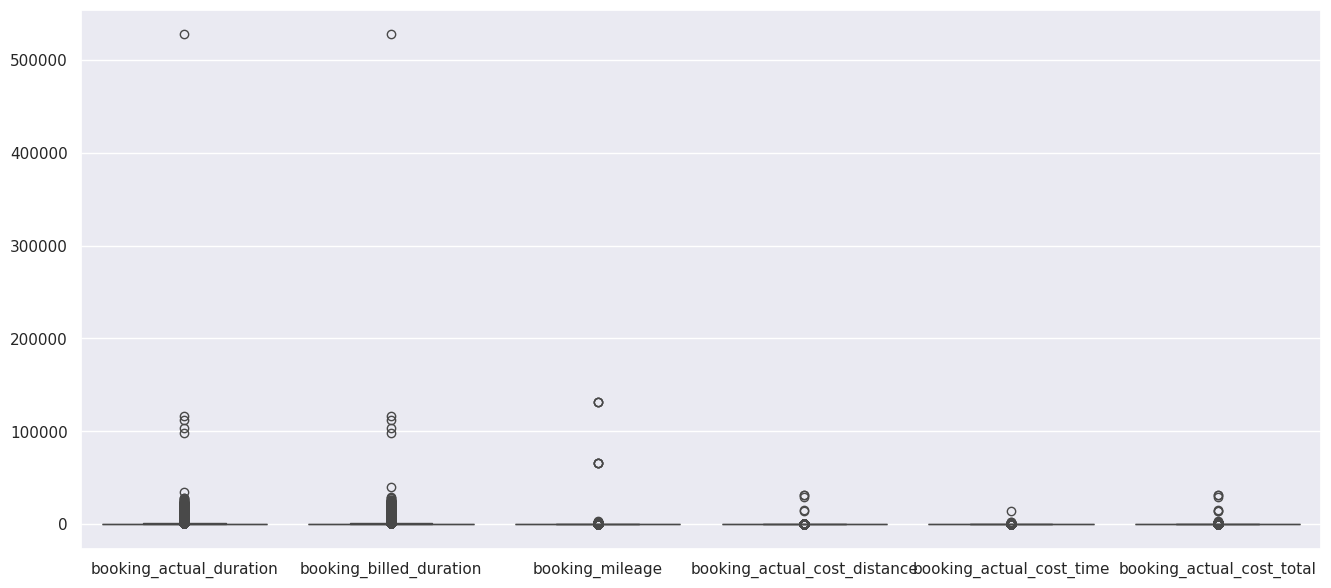

In [7]:
# Check for outliers using Box Plot
sns.set(rc={"figure.figsize":(16, 7)})
sns.boxplot(data=df[['booking_actual_duration', 'booking_billed_duration', 'booking_mileage',
                     'booking_actual_cost_distance', 'booking_actual_cost_time', 'booking_actual_cost_total']])
plt.show()

From the above plot, we can see that there are many outliers in all important variables. So, let's tackle these outliers of present features using IQR (Interquartile range) method.

In [8]:
# Check for outliers using IQR
Q1 = df[['booking_actual_duration', 'booking_billed_duration', 'booking_mileage', 'booking_actual_cost_distance', 'booking_actual_cost_time', 'booking_actual_cost_total']].quantile(0.25)
Q3 = df[['booking_actual_duration', 'booking_billed_duration', 'booking_mileage', 'booking_actual_cost_distance', 'booking_actual_cost_time', 'booking_actual_cost_total']].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers_iqr = ((df[['booking_actual_duration', 'booking_billed_duration', 'booking_mileage', 'booking_actual_cost_distance', 'booking_actual_cost_time', 'booking_actual_cost_total']] < lower_bound) |
                (df[['booking_actual_duration', 'booking_billed_duration', 'booking_mileage', 'booking_actual_cost_distance', 'booking_actual_cost_time', 'booking_actual_cost_total']] > upper_bound))

### 2.7.2. Handling Outliers using Capping and Flooring

In [9]:
# Handling outliers by capping and flooring
df['booking_actual_duration'] = np.where(df['booking_actual_duration'] > upper_bound['booking_actual_duration'], upper_bound['booking_actual_duration'], df['booking_actual_duration'])
df['booking_actual_duration'] = np.where(df['booking_actual_duration'] < lower_bound['booking_actual_duration'], lower_bound['booking_actual_duration'], df['booking_actual_duration'])

df['booking_billed_duration'] = np.where(df['booking_billed_duration'] > upper_bound['booking_billed_duration'], upper_bound['booking_billed_duration'], df['booking_billed_duration'])
df['booking_billed_duration'] = np.where(df['booking_billed_duration'] < lower_bound['booking_billed_duration'], lower_bound['booking_billed_duration'], df['booking_billed_duration'])

df['booking_mileage'] = np.where(df['booking_mileage'] > upper_bound['booking_mileage'], upper_bound['booking_mileage'], df['booking_mileage'])
df['booking_mileage'] = np.where(df['booking_mileage'] < lower_bound['booking_mileage'], lower_bound['booking_mileage'], df['booking_mileage'])

df['booking_actual_cost_distance'] = np.where(df['booking_actual_cost_distance'] > upper_bound['booking_actual_cost_distance'], upper_bound['booking_actual_cost_distance'], df['booking_actual_cost_distance'])
df['booking_actual_cost_distance'] = np.where(df['booking_actual_cost_distance'] < lower_bound['booking_actual_cost_distance'], lower_bound['booking_actual_cost_distance'], df['booking_actual_cost_distance'])

df['booking_actual_cost_time'] = np.where(df['booking_actual_cost_time'] > upper_bound['booking_actual_cost_time'], upper_bound['booking_actual_cost_time'], df['booking_actual_cost_time'])
df['booking_actual_cost_time'] = np.where(df['booking_actual_cost_time'] < lower_bound['booking_actual_cost_time'], lower_bound['booking_actual_cost_time'], df['booking_actual_cost_time'])

df['booking_actual_cost_total'] = np.where(df['booking_actual_cost_total'] > upper_bound['booking_actual_cost_total'], upper_bound['booking_actual_cost_total'], df['booking_actual_cost_total'])
df['booking_actual_cost_total'] = np.where(df['booking_actual_cost_total'] < lower_bound['booking_actual_cost_total'], lower_bound['booking_actual_cost_total'], df['booking_actual_cost_total'])

In [10]:
df.head()

,vehicle_description,vehicle_registration,location,booking_id,booking_actual_start,booking_actual_end,booking_actual_duration,booking_billed_start,booking_billed_end,booking_billed_duration,booking_mileage,booking_rates_hours,booking_rates_24hours,booking_rates_overnight,booking_actual_cost_distance,booking_actual_cost_time,booking_actual_cost_total,booking_created_at,Vehicle Type,Fuel Type,hourly_rate,daily_rate,per_mile
0,RETIRED - White Toyota Aygo X-Play Nav (NL66 NKZ),NL66 NKZ,Bristol,fc59ba9c-2ce9-11ea-8efc-bfa292f04054,2020-01-01 23:06:00,2020-01-02 01:24:00,138.0,2020-01-01 23:00:00,2020-01-02 08:00:00,540.0,82.0,0.0,0.0,1.0,14.76,9.50,24.26,2020-01-01 22:56:00,City,Petrol,4.75,33.25,0.18
1,RETIRED - Renault Zoe EV (DL68 LNK),DL68 LNK,Bristol,1cf7fae6-2ce7-11ea-a970-fbf7b3786523,2020-01-01 22:46:00,2020-01-02 02:01:00,195.0,2020-01-01 22:45:00,2020-01-02 02:30:00,225.0,5.0,0.0,0.0,1.0,0.00,11.00,11.00,2020-01-01 22:36:00,Everyday,EV,5.50,38.50,0.18
2,White Toyota Yaris Petrol Hybrid (Automatic) -...,ND19 HWY,Newbury,591b7a98-2cd8-11ea-a341-71665a42c0e8,2020-01-01 21:29:00,2020-01-01 23:28:00,119.0,2020-01-01 21:30:00,2020-01-01 23:30:00,120.0,6.0,2.0,0.0,0.0,1.08,11.00,12.08,2020-01-01 20:50:00,Everyday,Petrol,5.50,38.50,0.18
3,RETIRED - White Toyota Aygo X-Play (NL68 JVP),NL68 JVP,Swindon,b6177928-2c55-11ea-a2e0-e9685b57c653,2020-01-01 21:22:00,2020-01-01 21:38:00,16.0,2020-01-01 21:15:00,2020-01-01 21:45:00,30.0,6.0,0.5,0.0,0.0,1.08,2.38,3.46,2020-01-01 05:15:00,City,Petrol,4.75,33.25,0.18
4,RETIRED - White Toyota Yaris Hybrid NJ68 JHV A...,NJ68 JHV,Horsham,9ffdc790-27ba-11ea-a36d-c540c1997f03,2020-01-01 22:02:00,2020-01-02 19:50:00,733.0,2020-01-01 20:30:00,2020-01-02 20:30:00,915.0,53.0,0.0,1.0,0.0,9.54,38.50,48.04,2019-12-26 08:35:00,Everyday,Petrol,5.50,38.50,0.18


In [11]:
df.shape

(378614, 23)

### 2.7.3. Checking if outliers are replaced

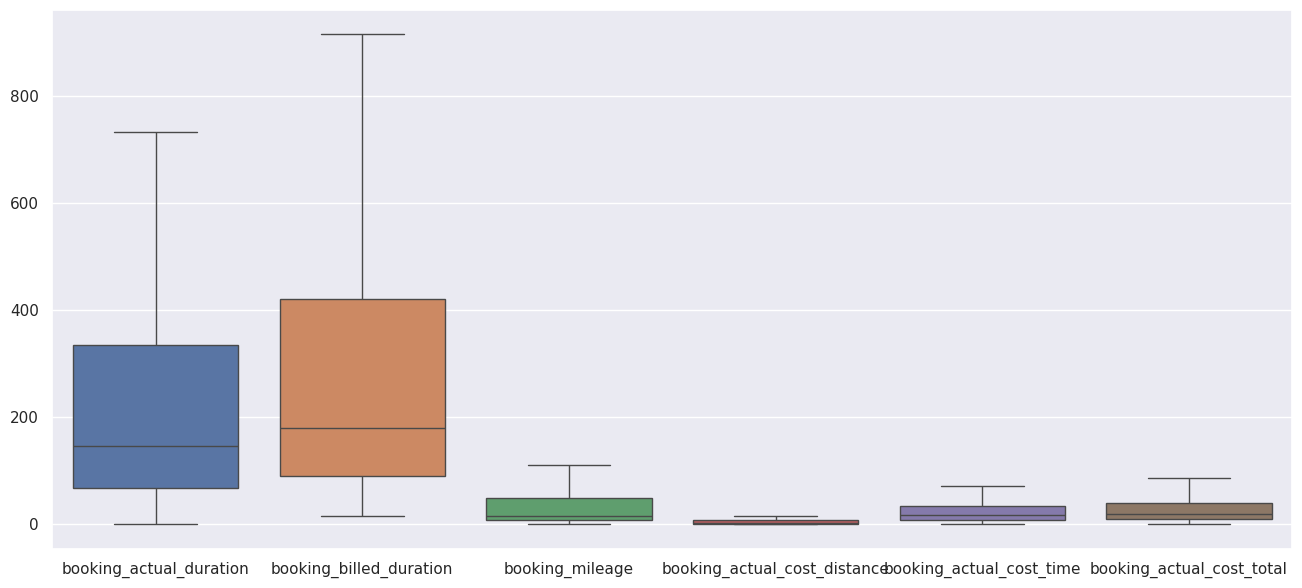

In [12]:
# Check if outliers are replaced
sns.set(rc={"figure.figsize":(16, 7)})
sns.boxplot(data=df[['booking_actual_duration', 'booking_billed_duration', 'booking_mileage',
                     'booking_actual_cost_distance', 'booking_actual_cost_time', 'booking_actual_cost_total']])
plt.show()

In [13]:
df.describe()

,booking_actual_start,booking_actual_end,booking_actual_duration,booking_billed_start,booking_billed_end,booking_billed_duration,booking_mileage,booking_rates_hours,booking_rates_24hours,booking_rates_overnight,booking_actual_cost_distance,booking_actual_cost_time,booking_actual_cost_total,booking_created_at,hourly_rate,daily_rate,per_mile
count,378614,378614,378614.000000,378614,378614,378614.000000,378614.000000,378614.000000,378614.000000,378614.000000,378614.000000,378614.000000,378614.000000,378614,378614.000000,378614.000000,378614.000000
mean,2022-01-29 06:41:55.066743552,2022-01-29 13:48:59.839625216,243.357950,2022-01-29 06:23:59.504614144,2022-01-29 14:42:42.482897920,307.037616,33.267173,1.995167,0.310422,0.040902,4.736710,22.684558,28.440802,2022-01-25 16:15:00.626759936,5.978310,44.821423,0.184128
min,2018-12-31 02:25:00,2018-12-31 03:50:00,0.000000,2018-12-31 02:30:00,2018-12-31 04:15:00,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.690000,0.690000,2018-10-21 21:30:00,4.750000,33.250000,0.050000
25%,2021-02-04 15:39:15,2021-02-04 18:29:00,68.000000,2021-02-04 15:37:30,2021-02-04 19:03:45,90.000000,7.000000,0.500000,0.000000,0.000000,0.720000,8.380000,10.050000,2021-02-02 20:45:45,5.500000,38.500000,0.180000
50%,2022-03-06 08:16:00,2022-03-06 14:12:30,146.000000,2022-03-06 08:00:00,2022-03-06 14:30:00,180.000000,16.000000,1.500000,0.000000,0.000000,2.200000,16.500000,19.250000,2022-03-01 20:53:30,5.750000,46.000000,0.180000
75%,2023-04-05 19:14:30,2023-04-06 12:04:30,334.000000,2023-04-05 19:00:00,2023-04-06 12:41:15,420.000000,48.000000,3.000000,0.000000,0.000000,6.840000,33.250000,40.300000,2023-04-01 08:52:30,6.500000,52.000000,0.220000
max,2024-05-13 03:07:00,2024-05-13 12:47:00,733.000000,2024-05-12 23:45:00,2024-05-13 17:00:00,915.000000,109.500000,7.750000,367.000000,1.000000,16.020000,70.555000,85.675000,2024-05-12 22:28:00,9.900000,68.000000,0.270000
std,NaN,NaN,235.595634,NaN,NaN,297.970407,36.106269,1.797716,0.998751,0.198063,5.478877,18.275007,24.218073,NaN,0.783349,7.385414,0.042480


# 3. Adding hours, days, months, year

## 3.1. booking_actual_start

In [14]:
df['booking_actual_start_hour'] = df['booking_actual_start'].dt.hour
df['booking_actual_start_dayofweek'] = df['booking_actual_start'].dt.dayofweek
df['booking_actual_start_month'] = df['booking_actual_start'].dt.month
df['booking_actual_start_year'] = df['booking_actual_start'].dt.year

## 3.2. booking_actual_end

In [15]:
df['booking_actual_end_hour'] = df['booking_actual_end'].dt.hour
df['booking_actual_end_dayofweek'] = df['booking_actual_end'].dt.dayofweek
df['booking_actual_end_month'] = df['booking_actual_end'].dt.month
df['booking_actual_end_year'] = df['booking_actual_end'].dt.year

## 3.3. booking_billed_start

In [16]:
df['booking_billed_start_hour'] = df['booking_billed_start'].dt.hour
df['booking_billed_start_dayofweek'] = df['booking_billed_start'].dt.dayofweek
df['booking_billed_start_month'] = df['booking_billed_start'].dt.month
df['booking_billed_start_year'] = df['booking_billed_start'].dt.year

## 3.4. booking_billed_end

In [17]:
df['booking_billed_end_hour'] = df['booking_billed_end'].dt.hour
df['booking_billed_end_dayofweek'] = df['booking_billed_end'].dt.dayofweek
df['booking_billed_end_month'] = df['booking_billed_end'].dt.month
df['booking_billed_end_year'] = df['booking_billed_end'].dt.year

## 3.5. booking_created_at

In [18]:
df['booking_created_at_hour'] = df['booking_created_at'].dt.hour
df['booking_created_at_dayofweek'] = df['booking_created_at'].dt.dayofweek
df['booking_created_at_month'] = df['booking_created_at'].dt.month
df['booking_created_at_year'] = df['booking_created_at'].dt.year

In [19]:
df.head()

,vehicle_description,vehicle_registration,location,booking_id,booking_actual_start,booking_actual_end,booking_actual_duration,booking_billed_start,booking_billed_end,booking_billed_duration,booking_mileage,booking_rates_hours,booking_rates_24hours,booking_rates_overnight,booking_actual_cost_distance,booking_actual_cost_time,booking_actual_cost_total,booking_created_at,Vehicle Type,Fuel Type,hourly_rate,daily_rate,per_mile,booking_actual_start_hour,booking_actual_start_dayofweek,booking_actual_start_month,booking_actual_start_year,booking_actual_end_hour,booking_actual_end_dayofweek,booking_actual_end_month,booking_actual_end_year,booking_billed_start_hour,booking_billed_start_dayofweek,booking_billed_start_month,booking_billed_start_year,booking_billed_end_hour,booking_billed_end_dayofweek,booking_billed_end_month,booking_billed_end_year,booking_created_at_hour,booking_created_at_dayofweek,booking_created_at_month,booking_created_at_year
0,RETIRED - White Toyota Aygo X-Play Nav (NL66 NKZ),NL66 NKZ,Bristol,fc59ba9c-2ce9-11ea-8efc-bfa292f04054,2020-01-01 23:06:00,2020-01-02 01:24:00,138.0,2020-01-01 23:00:00,2020-01-02 08:00:00,540.0,82.0,0.0,0.0,1.0,14.76,9.50,24.26,2020-01-01 22:56:00,City,Petrol,4.75,33.25,0.18,23,2,1,2020,1,3,1,2020,23,2,1,2020,8,3,1,2020,22,2,1,2020
1,RETIRED - Renault Zoe EV (DL68 LNK),DL68 LNK,Bristol,1cf7fae6-2ce7-11ea-a970-fbf7b3786523,2020-01-01 22:46:00,2020-01-02 02:01:00,195.0,2020-01-01 22:45:00,2020-01-02 02:30:00,225.0,5.0,0.0,0.0,1.0,0.00,11.00,11.00,2020-01-01 22:36:00,Everyday,EV,5.50,38.50,0.18,22,2,1,2020,2,3,1,2020,22,2,1,2020,2,3,1,2020,22,2,1,2020
2,White Toyota Yaris Petrol Hybrid (Automatic) -...,ND19 HWY,Newbury,591b7a98-2cd8-11ea-a341-71665a42c0e8,2020-01-01 21:29:00,2020-01-01 23:28:00,119.0,2020-01-01 21:30:00,2020-01-01 23:30:00,120.0,6.0,2.0,0.0,0.0,1.08,11.00,12.08,2020-01-01 20:50:00,Everyday,Petrol,5.50,38.50,0.18,21,2,1,2020,23,2,1,2020,21,2,1,2020,23,2,1,2020,20,2,1,2020
3,RETIRED - White Toyota Aygo X-Play (NL68 JVP),NL68 JVP,Swindon,b6177928-2c55-11ea-a2e0-e9685b57c653,2020-01-01 21:22:00,2020-01-01 21:38:00,16.0,2020-01-01 21:15:00,2020-01-01 21:45:00,30.0,6.0,0.5,0.0,0.0,1.08,2.38,3.46,2020-01-01 05:15:00,City,Petrol,4.75,33.25,0.18,21,2,1,2020,21,2,1,2020,21,2,1,2020,21,2,1,2020,5,2,1,2020
4,RETIRED - White Toyota Yaris Hybrid NJ68 JHV A...,NJ68 JHV,Horsham,9ffdc790-27ba-11ea-a36d-c540c1997f03,2020-01-01 22:02:00,2020-01-02 19:50:00,733.0,2020-01-01 20:30:00,2020-01-02 20:30:00,915.0,53.0,0.0,1.0,0.0,9.54,38.50,48.04,2019-12-26 08:35:00,Everyday,Petrol,5.50,38.50,0.18,22,2,1,2020,19,3,1,2020,20,2,1,2020,20,3,1,2020,8,3,12,2019


---